In [1]:
import os
import os.path 
import cv2
import tkinter as tk
import tkinter.filedialog as fd
from PIL import Image, ImageEnhance
from skimage import transform, img_as_int, exposure, img_as_ubyte
import skimage.io as io
import skimage as si
import tkinter.messagebox as mb
import numpy as np
import matplotlib.pyplot as plt
from skimage.feature import blob_log, blob_doh, blob_dog
from scipy import ndimage, spatial
from cmath import inf
import sys
import numpy as np
from scipy.optimize import curve_fit
import json
from Bio import SeqIO
from skimage.filters import gaussian
import pandas as pd
from skimage.feature import peak_local_max
from sklearn.metrics import mean_squared_error
from numpy.linalg import norm
from math import floor, ceil, exp
from skimage.registration import phase_cross_correlation
from scipy import ndimage as ndi
from scipy.io import savemat
import Polywarp
import itertools
import scipy.spatial
import star
from skimage.restoration import rolling_ball

root = tk.Tk()
root.attributes("-topmost", True)
root.withdraw()

''

## Was the data collected in the ALEX regime?
 

In [2]:
#ALEX = False
ALEX = True
if ALEX:
    green_frames = np.add(1,np.multiply(2,range(10)))

## Choose the tile

In [3]:
tile = 1101
#tile = 1102
#tile = 1103
#tile = 1104

## Provide the matching coordinates for the tile

In [9]:
# DO NOT ERASE PREVIOUS COORDINATES. ADD NEW LINES AND LABEL THE EXPERIMENT

#230629_Ha_4N_ALEX_Tile_4
# coords_t_seq = np.array([916.060,1205.253]) #Insert matching bead coordinates here manually!
# coords_t_FRET = np.array([5950.260,626.753])

#230629_Ha_4N_ALEX_Tile_3
#coords_t_seq = np.array([1096.321,802.822]) #Insert matching bead coordinates here manually!
#coords_t_FRET = np.array([9239.586,232.976])

#230629_Ha_4N_ALEX_Tile2
#coords_t_seq = np.array([921.887,810.653]) #Insert matching bead coordinates here manually!
#coords_t_FRET = np.array([12187.162,248.885])

#230629_Ha_4N_ALEX_Tile1
coords_t_seq = np.array([979,918]) #Insert matching bead coordinates here manually!
coords_t_FRET = np.array([15354,363])

#230619_Ha_4N_ALEX_Tile2
#coords_t_seq = np.array([1206.785,1683.35]) #Insert matching bead coordinates here manually!
#coords_t_FRET = np.array([4925.71,971.897])

#230619_Ha_4N_ALEX_Tile1
#coords_t_seq = np.array([1433.198,952.483]) #Insert matching bead coordinates here manually!
#coords_t_FRET = np.array([8252.685,263.022])

#230524_CCR5_4N_ALEX_Tile2
#coords_t_seq = np.array([644.651,1219.301]) #Insert matching bead coordinates here manually!
#coords_t_FRET = np.array([4445.135,1329.623])

#230524_CCR5_4N_ALEX_Tile1
#coords_t_seq = np.array([1008.585,867.937]) #Insert matching bead coordinates here manually!
#coords_t_FRET = np.array([7904.412,992.510])

#230503_CCR5_4N_ALEX_Tile2
#coords_t_seq = np.array([1497.5,459.5]) #Insert matching bead coordinates here manually!
#coords_t_FRET = np.array([7869.046,950.123])

#230215_Tile_3
#coords_t_seq = np.array([2472.485,1187.175]) #Insert matching bead coordinates here manually!
#coords_t_FRET = np.array([9029.710,1510.853])

#2023-01-26 Tile 1
#coords_t_seq = np.array([1537.5,1398]) #Insert matching bead coordinates here manually!
#coords_t_FRET = np.array([6335,1470.5])
#2023-01-26 Tile 2
# coords_t_seq = np.array([1447.4,1449.7]) #Insert matching bead coordinates here manually!
# coords_t_FRET = np.array([3118.5,1499.8])

#2023-01-23 Tile 1
# coords_t_seq = np.array([1505.5,1481.8]) #Insert matching bead coordinates here manually!
# coords_t_FRET = np.array([6893.9,1298.6])
#2023-01-23 Tile 2
# coords_t_seq = np.array([829,1559.8]) #Insert matching bead coordinates here manually!
# coords_t_FRET = np.array([3111.6,1353.6])

#2022-12-27 Tile 1
# coords_t_seq = np.array([1451.532,1204.410]) #Insert matching bead coordinates here manually!
# coords_t_FRET = np.array([3739.046,1271.476])
#2022-12-27 Tile 2
# coords_t_seq = np.array([2577.568,1054.075]) #Insert matching bead coordinates here manually!
# coords_t_FRET = np.array([1751.353,1126.065])

#2023-01-16 Tile 1
# coords_t_seq = np.array([2067,348]) #Insert matching bead coordinates here manually!
# coords_t_FRET = np.array([8813, 785]) 
#2023-01-16 Tile 2
# coords_t_seq = np.array([986,888]) #Insert matching bead coordinates here manually!
# coords_t_FRET = np.array([4644, 1300]) 

#2023-01-17 Tile 1
# coords_t_seq = np.array([1525.5,1810.6]) #Insert matching bead coordinates here manually!
# coords_t_FRET = np.array([7238, 970.6]) 
#2023-01-17 Tile 2
# coords_t_seq = np.array([1333.4,1987.6]) #Insert matching bead coordinates here manually!
# coords_t_FRET = np.array([3971.3, 1154.7]) 


In [10]:
def proposecands(uknquadlist, refquadlist, n=5, verbose=True):
    """
    Function that identifies similar quads between the unknown image and a reference.
    Returns a dict of (uknquad, refquad, dist, trans)
    """
    # Nothing to do if the quadlists are empty ...
    if len(uknquadlist) == 0 or len(refquadlist) == 0:
        if verbose:
            print("No quads to propose ...")
        return []

    if verbose:
        print("Finding %i best candidates among %i x %i (ukn x ref)" % (n, len(uknquadlist), len(refquadlist)))
    uknhashs = np.array([q.hash for q in uknquadlist])
    refhashs = np.array([q.hash for q in refquadlist])

    # Brute force...
    dists = scipy.spatial.distance.cdist(refhashs, uknhashs)
    uknmindistindexes = np.argmin(dists, axis=0)  # For each ukn, the index of the closest ref
    uknmindist = np.min(dists, axis=0)  # The corresponding distances
    uknbestindexes = np.argsort(uknmindist)

    candlist = []
    nmax = len(uknbestindexes)
    if verbose:
        print("We have a maximum of %i quad pairs" % (nmax))
    for i in range(min(n, nmax)):

        cand = {"uknquad": uknquadlist[uknbestindexes[i]], "refquad": refquadlist[uknmindistindexes[uknbestindexes[i]]],
                "dist": uknmindist[uknbestindexes[i]]}

        cand["trans"] = quadtrans(cand["uknquad"], cand["refquad"])
        print ((abs(cand["trans"].getrotation())), cand["dist"]) 
        if (abs(cand["trans"].getrotation()) < 5): 
             candlist.append(cand)
             if verbose:
                 print("Cand %2i (dist. %12.8f) : %s" % (i+1, cand["dist"], str(cand["trans"])))

    return candlist


"""
Overhaul of cosmouline's star module, for alipy2.
This module contains stuff for geometric matching algorithms.
"""

import sys
import os
import math
import numpy as np
import operator  # For sorting
import copy
import scipy.linalg
import scipy.spatial


class Dots:
    """
    Simple class to represent a single source (usually stars, but not necessarily).
    In this module we often manipulate lists of such Dots objects.
    """

    def __init__(self, x=0.0, y=0.0, props={}, fwhm=-1.0, elon=-1.0):
        """
        flux : Some "default" or "automatic" flux, might be a just good guess. Used for sorting etc.
        If you have several fluxes, colours, store them in the props dict.
        props : A placeholder dict to contain other properties of your choice (not required nor used by the methods).
        """
        self.x = float(x)
        self.y = float(y)
        
       
    def copy(self):
        return copy.deepcopy(self)

    def __getitem__(self, key):
        """
        Used for sorting list of stars.
        """
        if key == 'flux':
            return self.flux
        if key == 'fwhm':
            return self.fwhm
        if key == 'elon':
            return self.elon

  
    
    def coords(self, full=False):
        """
        Returns the coords in form of an array.

        :param full: If True, I also include flux, fwhm, elon
        :type full: boolean

        """
        if full:
            return np.array([self.x, self.y, self.flux, self.fwhm, self.elon])
        else:
            return np.array([self.x, self.y])

    def distance(self, otherstar):
        """
        Returns the distance between the two stars.
        """
        return math.sqrt(np.sum((self.coords() - otherstar.coords())**2))

    def distanceandsort(self, otherstarlist):
        """
        Returns a list of dicts(star, dist, origpos), sorted by distance to self.
        The 0th star is the closest.

        otherstarlist is not modified.
        """

        returnlist = []
        for i, star in enumerate(otherstarlist):
            dist = self.distance(star)
            returnlist.append({'dot': star, 'dist': dist, 'origpos': i})
        returnlist = sorted(returnlist, key=operator.itemgetter('dist'))  # sort stars according to dist

        return returnlist

# And now some functions to manipulate list of such stars ###


def listtoarray(starlist, full=False):
    """
    Transforms the starlist into a 2D numpy array for fast manipulations.
    First index is star, second index is x or y

    :param full: If True, I also include flux, fwhm, elon
    :type full: boolean

    """
    return np.array([star.coords(full=full) for star in starlist])


def area(dotlist, border=0.01):
    """
    Returns the area covered by the dots.
    Border is relative to max-min
    """
    if len(dotlist) == 0:
        return np.array([0, 1, 0, 1])

    if len(dotlist) == 1:
        dot = dotlist[0]
        return np.array([dot.x - 0.5, dot.x + 0.5, dot.y - 0.5, dot.y + 0.5])

    a = listtoarray(starlist)
    (xmin, xmax) = (np.min(a[:, 0]), np.max(a[:, 0]))
    (ymin, ymax) = (np.min(a[:, 1]), np.max(a[:, 1]))
    xw = xmax - xmin
    yw = ymax - ymin
    xmin = xmin - border*xw
    xmax = xmax + border*xw
    ymin = ymin - border*yw
    ymax = ymax + border*yw
    return np.array([xmin, xmax, ymin, ymax])


class Quad:
    """
    A geometric "hash", or asterism, as used in Astrometry.net :
    http://adsabs.harvard.edu/cgi-bin/bib_query?arXiv:0910.2233
    It is made out of 4 stars, and it is shift / scale / rotation invariant
    """

    def __init__(self, fourstars):
        """
        fourstars is a list of four stars

        We make the following attributes :
        self.hash
        self.stars (in the order A, B, C, D)

        """
        assert len(fourstars) == 4

        tests = [(0, 1), (0, 2), (0, 3), (1, 2), (1, 3), (2, 3)]
        other = [(2, 3), (1, 3), (1, 2), (0, 3), (0, 2), (0, 1)]
        dists = np.array([fourstars[i].distance(fourstars[j]) for (i, j) in tests])
        assert np.min(dists) > 1.0

        maxindex = np.argmax(dists) # Returns the indices of the maximum values along an axis
        (Ai, Bi) = tests[maxindex]  # Indexes of stars A and B
        (Ci, Di) = other[maxindex]  # Indexes of stars C and D
        
        A = fourstars[Ai]
        B = fourstars[Bi]
        C = fourstars[Ci]
        D = fourstars[Di]

        # We look for matrix transform [[a -b], [b a]] + [c d] that brings A and B to 00 11 :
        
        
        x = B.x - A.x
        if x == 0:
            x = x+0.01
        y = B.y - A.y
        b = (x-y)/(x*x + y*y)
        a = (1.0/x) * (1.0 + b*y)
        c = b*A.y - a*A.x
        d = - (b*A.x + a*A.y)

        t = star.SimpleTransform((a, b, c, d))

        (xC, yC) = t.apply(C.x, C.y)
        (xD, yD) = t.apply(D.x, D.y)

        # Normal case
        self.hash = (xC, yC, xD, yD)

        # Break symmetries :
        testa = xC > xD
        testb = xC + xD > 1

        if testa and not testb:  # we switch C and D
            self.hash = (xD, yD, xC, yC)
            (C, D) = (D, C)

        if testb and not testa:  # We switch A and B
            self.hash = (1.0-xD, 1.0-yD, 1.0-xC, 1.0-yC)
            (A, B) = (B, A)
            (C, D) = (D, C)

        if testa and testb:
            self.hash = (1.0-xC, 1.0-yC, 1.0-xD, 1.0-yD)
            (A, B) = (B, A)

        # Checks :
        assert self.hash[0] <= self.hash[2]
        assert self.hash[0] + self.hash[2] <= 1

        self.stars = [A, B, C, D]  # Order might be different from the fourstars !

    def __str__(self):
        return "Hash : %6.3f %6.3f %6.3f %6.3f " % (
            self.hash[0], self.hash[1], self.hash[2], self.hash[3])

    
def distance(self, otherstar):
        """
        Returns the distance between the two stars.
        """
        return math.sqrt(np.sum((self.coords() - otherstar.coords())**2))

def mindist(fourstars):
    """
    Function that tests if 4 stars are suitable to make a good quad...
    """
    tests = [(0, 1), (0, 2), (0, 3), (1, 2), (1, 3), (2, 3)]
    dists = np.array([fourstars[i].distance(fourstars[j]) for (i, j) in tests])
    return np.min(dists)



def makequads1(center_coord, n=10, s=0, d=10, verbose=True):
    """
    First trivial quad maker.
    Makes combis of the n brightest stars.

    :param n: number of stars to consider (brightest ones).
    :type n: int
    :param s: how many of the brightest stars should I skip ?
        This feature is useful to avoid building quads with nearly saturated stars that are not
        available in other exposures.
    :type s: int
    :param d: minimal distance between stars
    :type d: float

    """
    quadlist = []
     

    for fourdots in itertools.combinations(center_coord[s:s+n], 4):
        if mindist(fourdots) > d:
                quadlist.append(Quad(fourdots))

    if verbose:
        print("Made %4i quads from %4i stars (combi n=%i s=%i d=%.1f)" % (len(quadlist), len(center_coord), n, s, d))

    return quadlist

def makequads2(dotlist, f=5.0, n=6, s=0, d=50.0, verbose=True):
    """
    Similar, but fxf in subareas roughly f times smaller than the full frame.
    s allows to skip the brightest stars in each region

    :param f: smallness of the subareas
    :type f: float
    :param n: number of stars to consider in each subarea
    :type n: int
    :param d: minimal distance between stars
    :type d: float
    :param s: number of brightest stars to skip in each subarea
    :type s: int

    """
    quadlist = []
    
    (xmin, xmax, ymin, ymax) = star.area(dotlist)

    r = 2.0 * max(xmax - xmin, ymax - ymin) / f

    for xc in np.linspace(xmin, xmax, int(f)+2)[1:-1]:
        for yc in np.linspace(ymin, ymax, int(f)+2)[1:-1]:
            dot = Dots(x=xc, y=yc)
            das = dot.distanceandsort(dotlist)
            elmnt = [element["dot"] for element in das if element["dist"] <= r]
            brightestwithinr = elmnt[s:s+n]
            for fourstars in itertools.combinations(brightestwithinr, 4):
                if mindist(fourstars) > d:
                    quadlist.append(Quad(fourstars))

    if verbose:
        print("Made %4i quads from %4i stars (combi sub f=%.1f n=%i s=%i d=%.1f)" % (len(quadlist), len(dotlist),
                                                                                     f, n, s, d))
    return quadlist


class ImgCat:
    """
    Represent an individual image and its associated catalog, starlist, quads etc.
    """

    def __init__(self, centers):
        """

        :param filepath: Path to the FITS file, or alternatively just a string to identify the image.
        :type filepath: string

        
        """
        self.filepath = 'default'
#         print (self.filepath)
#         (imgdir, filename) = path.split(filepath)
#         (common, ext) = path.splitext(filename)
        self.name = 'default'

       
        self.dotlist = []
        for row in centers: 
            self.dotlist.append(Dots(row[0], row[1]))      
        (xmin, xmax, ymin, ymax) = star.area(self.dotlist, border=0.01)
        self.xlim = (xmin, xmax)
        self.ylim = (ymin, ymax)
        
        self.mindist = 0.0
        self.xlim = (0.0, 0.0)  # Will be set using the catalog -- no need for the FITS image.
        self.ylim = (0.0, 0.0)

        self.quadlist = []
        self.quadlevel = 0  # encodes what kind of quads have already been computed

    def __str__(self):
        return "%20s: approx %4i x %4i, %4i stars, %4i quads, quadlevel %i" % (path.basename(self.filepath),
                                                                               self.xlim[1] - self.xlim[0],
                                                                               self.ylim[1] - self.ylim[0],
                                                                               len(self.starlist), len(self.quadlist),
                                                                               self.quadlevel)

    def makemorequads(self, verbose=True):
        """
        We add more quads, following the quadlevel.
        """
        # if not add:
        #    self.quadlist = []
        if verbose:
            print("Making more quads, from quadlevel %i ..." % self.quadlevel)
        if self.quadlevel == 0:
            self.quadlist.extend(makequads1(self.dotlist, n=10, d=self.mindist, verbose=verbose))
        elif self.quadlevel == 1:
            self.quadlist.extend(makequads2(self.dotlist, f=3, n=10, d=self.mindist, verbose=verbose))
        elif self.quadlevel == 2:
            self.quadlist.extend(makequads2(self.dotlist, f=6, n=10, d=self.mindist, verbose=verbose))
        elif self.quadlevel == 3:
            self.quadlist.extend(makequads2(self.dotlist, f=12, n=10, d=self.mindist, verbose=verbose))
        elif self.quadlevel == 4:
            self.quadlist.extend(makequads2(self.dotlist, f=15, n=10, s=0, d=self.mindist, verbose=verbose))
        elif self.quadlevel == 5:
            self.quadlist.extend(makequads2(self.dotlist, f=18, n=10, s=0, d=self.mindist, verbose=verbose))
        elif self.quadlevel == 6:
            self.quadlist.extend(makequads2(self.dotlist, f=21, n=10, s=0, d=self.mindist, verbose=verbose))
        elif self.quadlevel == 7:
            self.quadlist.extend(makequads2(self.dotlist, f=24, n=10, s=0, d=self.mindist, verbose=verbose))  
        elif self.quadlevel == 8:
            self.quadlist.extend(makequads2(self.dotlist, f=27, n=10, s=0, d=self.mindist, verbose=verbose))  
        elif self.quadlevel == 9:
            self.quadlist.extend(makequads2(self.dotlist, f=30, n=10, s=0, d=self.mindist, verbose=verbose)) 
        elif self.quadlevel == 10:
            self.quadlist.extend(makequads2(self.dotlist, f=33, n=10, s=0, d=self.mindist, verbose=verbose))   
        elif self.quadlevel == 11:
            self.quadlist.extend(makequads2(self.dotlist, f=36, n=10, s=0, d=self.mindist, verbose=verbose))  
        elif self.quadlevel == 12:
            self.quadlist.extend(makequads2(self.dotlist, f=39, n=10, s=0, d=self.mindist, verbose=verbose))    
        elif self.quadlevel == 13:
            self.quadlist.extend(makequads2(self.dotlist, f=42, n=10, s=0, d=self.mindist, verbose=verbose)) 
        elif self.quadlevel == 14:
            self.quadlist.extend(makequads2(self.dotlist, f=45, n=10, s=0, d=self.mindist, verbose=verbose)) 
        else:
            return False

        self.quadlist = removeduplicates(self.quadlist, verbose=verbose)
        self.quadlevel += 1
        return True
    
def removeduplicates(quadlist, verbose=True):
    """
    Returns a quadlist without quads with identical hashes...
    """
    # To avoid crash in lexsort if quadlist is too small :
    if len(quadlist) < 2:
        return quadlist
    hasharray = np.array([q.hash for q in quadlist])

    order = np.lexsort(hasharray.T)
    hasharray = hasharray[order]
    diff = np.fabs(np.diff(hasharray, axis=0))
    ui = np.ones(len(hasharray), 'bool')
    ui[1:] = (diff >= 0.000001).any(axis=1)
    if verbose:
        print("Removing %i/%i duplicates" % (len(quadlist) - np.sum(ui), len(quadlist)))

    return [quad for (quad, u) in zip(quadlist, ui) if u]
def quadtrans(uknquad, refquad):
    """
    Quickly return a transform estimated from the stars A and B of two quads.
    """
    return star.fitstars(uknquad.stars[:2], refquad.stars[:2])



class Identification:
    """
    Represents the identification of a transform between two ImgCat objects.
    Regroups all the star catalogs, the transform, the quads, the candidate, etc.

    All instance attributes are listed below.

    :ivar ref: ImgCat object of the reference image
    :ivar ukn: ImgCat object of the unknown image
    :ivar ok: boolean, True if the idendification was successful.
    :ivar trans: The SimpleTransform object that represents the geometrical transform from ukn to ref.
    :ivar uknmatchstars: A list of Star objects of the catalog of the unknown image...
    :ivar refmatchstars: ... that correspond to these Star objects of the reference image.
    """

    def __init__(self, ref, ukn):
        """
        :param ref: The reference image
        :type ref: ImgCat object
        :param ukn: The unknown image, whose transform will be adjusted to match the ref
        :type ukn: ImgCat object
        """
        self.ref = ref
        self.ukn = ukn

        self.ok = False

        self.trans = None
        self.uknmatchstars = []
        self.refmatchstars = []
        self.cand = None

    def findtrans(self, r=5.0, verbose=False):
        """
        Find the best trans given the quads, and tests if the match is sufficient
        """

        # Some robustness checks
        if len(self.ref.dotlist) < 4:
            if verbose:
                print("Not enough dot in the reference catalog.")
            return
        if len(self.ukn.dotlist) < 4:
            if verbose:
                print("Not enough dot in the unknown catalog.")
            return

        # First question : how many stars should match ?
        if len(self.ukn.dotlist) < 5:  # Then we should simply try to get the smallest distance...
            minnident = 4
        else:
            minnident = max(4, min(8, len(self.ukn.dotlist)/5.0))  # Perfectly arbitrary, let's see how it works

        # Hmm, arbitrary for now :
        minquaddist = 0.02

        # Let's start :
        if self.ref.quadlevel == 0:
            self.ref.makemorequads(verbose=verbose)
        if self.ukn.quadlevel == 0:
            self.ukn.makemorequads(verbose=verbose)

        while self.ok is False:
            # Find the best candidates
            cands = proposecands(self.ukn.quadlist, self.ref.quadlist, n=4, verbose=verbose)

            if len(cands) != 0 and cands[0]["dist"] < minquaddist:
                # If no quads are available, we directly try to make more ones.
                for cand in cands:
                    # Check how many stars are identified...
                    nident = star.identify(self.ukn.dotlist, self.ref.dotlist, trans=cand["trans"],
                                           r=r, verbose=verbose, getstars=False)
                    if nident >= minnident:
                        self.trans = cand["trans"]
                        self.cand = cand
                        self.ok = True
                        break  # get out of the for

            if self.ok is False:
                # We add more quads...
                addedmorerefquads = self.ref.makemorequads(verbose=verbose)
                addedmoreuknquads = self.ukn.makemorequads(verbose=verbose)

                if addedmorerefquads is False and addedmoreuknquads is False:
                    break  # get out of the while, we failed.

        #if  ((self.ok) and (abs(self.trans.getrotation()))<5):  # we refine the transform
        if  (self.ok) :
            # get matching stars :
            (self.uknmatchstars, self.refmatchstars) = star.identify(self.ukn.dotlist, self.ref.dotlist,
                                                                     trans=self.trans, r=r, verbose=False,
                                                                     getstars=True)
            # refit the transform on them :
            if verbose:
                print("Refitting transform (before/after) :")
                print(self.trans)
            newtrans = star.fitstars(self.uknmatchstars, self.refmatchstars)
            if newtrans is not None:
                self.trans = newtrans
                if verbose:
                    print(self.trans)
            # Generating final matched star lists :
            (self.uknmatchstars, self.refmatchstars) = star.identify(self.ukn.dotlist, self.ref.dotlist,
                                                                     trans=self.trans, r=r, verbose=verbose,
                                                                     getstars=True)

            if verbose:
                print("I'm done!")

        else:
            if verbose:
                print("Failed to find transform!")

 
def run(ref, ukns, skipsaturated=False, r=5.0, n=500, sexkeepcat=False, sexrerun=True,
        verbose=False, polarMode=None, refpolar=False, camera=None):
    """
    Top-level function to identify transorms between images.
    Returns a list of Identification objects that contain all the info to go further.

    :param ref: coordinates of beads in a reference image.
    :type ref: np.array(:,2)

    :param ukns: coordinates of beads in an unknown image.
    :type ukns: np.array(:,2)

    :param hdu: The hdu of the fits files (same for all) that you want me to use. 0 is somehow "automatic".
    If multihdu, 1 is usually science.

    if the identification fails).

    :param skipsaturated: Should I skip saturated stars ?
    :type skipsaturated: boolean

    :param r: Identification radius in pixels of the reference image (default 5.0 should be fine).
    :type r: float
    :param n: Number of brightest stars of each image to consider (default 500 should be fine).
    :type n: int

    :param sexkeepcat: Put this to True if you want me to keep the SExtractor catalogs (in a dir "alipy_cats").
    :type sexkeepcat: boolean
    :param sexrerun: Put this to False if you want me to check if I have some previously kept catalogs
    (with sexkeepcat=True), instead of running SExtractor again on the images.
    :type sexrerun: boolean
    """

    if verbose:
        print(10*"#", " Preparing reference ...")
    ref = ImgCat(ref)
    
    ref.makemorequads(verbose=verbose)

    identifications = []

   

    if verbose:
            print(10*"#", "Processing %s" % (ukns))

    ukn = ImgCat(ukns)
        
    idn = Identification(ref, ukn)
    idn.findtrans(verbose=verbose, r=r)
    identifications.append(idn)

    return identifications

def identify(uknstars, refstars, trans=None, r=5.0, verbose=True, getstars=False):
    """
    Allows to:
     * get the number or matches, i.e. evaluate the quality of the trans
     * get corresponding stars from both lists (without the transform applied)

    :param getstars: If True, I return two lists of corresponding stars, instead of just the number of matching stars
    :type getstars: boolean

    Inspired by the "formpairs" of alipy 1.0 ...

    """

    if trans is not None:
        ukn = listtoarray(trans.applystarlist(uknstars))
    else:
        ukn = listtoarray(uknstars)
    ref = listtoarray(refstars)

    dists = scipy.spatial.distance.cdist(ukn, ref)  # Big table of distances between ukn and ref
    mindists = np.min(dists, axis=1)  # For each ukn, the minimal distance
    minok = mindists <= r  # booleans for each ukn
    minokindexes = np.argwhere(minok).flatten()  # indexes of uknstars with matches

    if verbose:
        print("%i/%i stars with distance < r = %.1f (mean %.1f, median %.1f, std %.1f)" % (np.sum(minok),
                                                                                           len(uknstars), r,
                                                                                           np.mean(mindists[minok]),
                                                                                           np.median(mindists[minok]),
                                                                                           np.std(mindists[minok])))
    matchuknstars = []
    matchrefstars = []

    for i in minokindexes:  # we look for the second nearest ...
        sortedrefs = np.argsort(dists[i, :])
        firstdist = dists[i, sortedrefs[0]]
        seconddist = dists[i, sortedrefs[1]]
        if seconddist > 2.0*firstdist:  # Then the situation is clear, we keep it.
            matchuknstars.append(uknstars[i])
            matchrefstars.append(refstars[sortedrefs[0]])
        else:
            pass  # Then there is a companion, we skip it.

    if verbose:
        print("Filtered for companions, keeping %i/%i matches" % (len(matchuknstars), np.sum(minok)))

    if getstars is True:
        return (matchuknstars, matchrefstars)
    else:
        return len(matchuknstars)

    
def find_max (x,y, arr):
    
#     print(np.shape(arr))
#     print((arr))
    max_elem = -1
    for i in range(x-5, x+6):
        for j in range(y-5, y+6):
            if arr[j][i] > max_elem:
                max_elem =  arr[j][i]

    list_index_max =[(i,j) for i in range(x-5, x+6)  for j in range(y-5, y+6) if arr[j][i]  == max_elem]
    line, column = list_index_max[0]
    return(line, column)
#https://www.geeksforgeeks.org/displaying-the-coordinates-of-the-points-clicked-on-the-image-using-python-opencv/  
# function to display the coordinates of  of the points clicked on the image

def click_event_FRET(event, x, y, flags, params):
    global counter
    global FRET_coord
    if event == cv2.EVENT_LBUTTONDOWN:   # checking for left mouse clicks   
        x_max,y_max = find_max(x,y,image_array_F)
#         print(x_max, y_max)
        FRET_coord.append(x_max) 
        FRET_coord.append(y_max)
        cv2.circle(better_contrast_img, (x_max, y_max), 4, (0, 0, 127), 2)
        counter+=1    
    if event==cv2.EVENT_RBUTTONDOWN:
        counter = 0
        green_coord.clear()
        red_coord.clear()
        
def click_event_seq(event, x, y, flags, params):
    global counter
    global seq_coord
    if event == cv2.EVENT_LBUTTONDOWN:   # checking for left mouse clicks   
        x_max,y_max = find_max(x,y,image_array_seq_t)
#         print(x_max, y_max)
        seq_coord.append(x_max) 
        seq_coord.append(y_max)
        cv2.circle(better_contrast_img_2, (x_max, y_max), 4, (0, 0, 127), 2)
        counter+=1   
    if event==cv2.EVENT_RBUTTONDOWN:
        counter = 0
        green_coord.clear()
        red_coord.clear()

In [6]:
# Alternative version of figuring out the displacement
file_path = fd.askopenfilename(title = "Choose the position list")

pos_file = open(file_path)
data = json.load(pos_file)
POS = data['POSITIONS']

labels = [P['LABEL'] for P in POS]
posX = [P['DEVICES'][1]['X'] for P in POS]
posY = [P['DEVICES'][1]['Y'] for P in POS]
# print(min(posX), max(posX), min(posY), max(posY))
upper_left_um_x = min(posX)
upper_left_um_y = max(posY)


#2023-01-26 Tile 1
# coords_t_seq = np.array([1537.5,1398]) #Insert matching bead coordinates here manually!
# coords_t_FRET = np.array([6335,1470.5])

#2023-01-26 Tile 2
# coords_t_seq = np.array([1447.4,1449.7]) #Insert matching bead coordinates here manually!
# coords_t_FRET = np.array([3118.5,1499.8])



#2023-01-23 Tile 1
# coords_t_seq = np.array([1505.5,1481.8]) #Insert matching bead coordinates here manually!
# coords_t_FRET = np.array([6893.9,1298.6])

#2023-01-23 Tile 2
# coords_t_seq = np.array([829,1559.8]) #Insert matching bead coordinates here manually!
# coords_t_FRET = np.array([3111.6,1353.6])

#2022-12-27 Tile 1
# coords_t_seq = np.array([1451.532,1204.410]) #Insert matching bead coordinates here manually!
# coords_t_FRET = np.array([3739.046,1271.476])

#2022-12-27 Tile 2
# coords_t_seq = np.array([2577.568,1054.075]) #Insert matching bead coordinates here manually!
# coords_t_FRET = np.array([1751.353,1126.065])

#2023-01-16 Tile 1
# coords_t_seq = np.array([2067,348]) #Insert matching bead coordinates here manually!
# coords_t_FRET = np.array([8813, 785]) 
#2023-01-16 Tile 2
# coords_t_seq = np.array([986,888]) #Insert matching bead coordinates here manually!
# coords_t_FRET = np.array([4644, 1300]) 

#2023-01-17 Tile 1
# coords_t_seq = np.array([1525.5,1810.6]) #Insert matching bead coordinates here manually!
# coords_t_FRET = np.array([7238, 970.6]) 
#2023-01-17 Tile 2
# coords_t_seq = np.array([1333.4,1987.6]) #Insert matching bead coordinates here manually!
# coords_t_FRET = np.array([3971.3, 1154.7]) 


[deltax, deltay] = np.subtract(coords_t_seq,coords_t_FRET)
print(deltax,deltay)
print(upper_left_um_x, upper_left_um_y)


-14375 701
23499.2 -723.5


In [7]:
# Initial match smFRET vs Seq
# deltax = 4660 # for tile 1 220815
# deltay = -25
# upper_left_um_x = 26091.3
# upper_left_um_y = -690

def get_pos(record):
    
    des = record.description
    tile_num = int(des.split(' ')[0].split(':')[4])
    x_pos = int(des.split(' ')[0].split(':')[5])
    y_pos = int(des.split(' ')[0].split(':')[6])
    return tile_num, x_pos, y_pos


def generate_img(x, y, x_min, y_min, x_max, y_max, r, blurred, sigma):
    # x_min = min(x)
    # x_max = max(x)
    # y_min = min(y)
    # y_max = max(y)
    x_range = x_max - x_min
    y_range = y_max - y_min
    # x_range = 27994
    # y_range = 27174
    img = np.zeros(shape=(x_range, y_range))
    for i in range(0, len(x)):
        img[min(x_range-1,max(0,int(x[i]-r))):min(x_range-1,max(0,int(x[i]+r+1))),min(y_range-1,max(0,int(y[i]-r))):min(y_range-1,max(0,int(y[i]+r+1)))] = 200

    if blurred:
        img = gaussian(img, sigma=sigma)
    im = Image.fromarray(img)
    new_im = im.convert("L")
#     new_im.save(op_path)
    return new_im


def generate_with_marker(x, y, marker_x, marker_y, op_path, csv_path):
    x_min = min(x)
    x_max = max(x)
    y_min = min(y)
    y_max = max(y)
    x_range = x_max - x_min + 1
    y_range = y_max - y_min + 1
    img = np.zeros(shape=(x_range, y_range, 3))
    marker_dic = {'index': range(0, len(marker_x)), 'x': [], 'y': []}
    for i in range(0, len(x)):
        for j in range(0, 5):
            for k in range(0, 5):
                img[max(0, x[i] - x_min - j),
                    max(0, y[i] - y_min - k), 0:3] = 255
                img[min(x_range - 1, x[i] - x_min + j),
                    max(0, y[i] - y_min - k), 0:3] = 255
                img[min(x_range - 1, x[i] - x_min + j),
                    min(y_range - 1, y[i] - y_min + k), 0:3] = 255
                img[max(0, x[i] - x_min - j),
                    min(y_range - 1, y[i] - y_min + k), 0:3] = 255
    for i in range(0, len(marker_x)):
        marker_dic['x'].append(marker_x[i] - x_min)
        marker_dic['y'].append(marker_y[i] - y_min)
        for j in range(0, 5):
            for k in range(0, 5):
                img[max(0, marker_x[i] - x_min - j),
                    max(0, marker_y[i] - y_min - k), 0] = 255
                img[max(0, marker_x[i] - x_min - j),
                    max(0, marker_y[i] - y_min - k), 1:3] = 0
                img[min(x_range - 1, marker_x[i] - x_min + j),
                    max(0, marker_y[i] - y_min - k), 0] = 255
                img[min(x_range - 1, marker_x[i] - x_min + j),
                    max(0, marker_y[i] - y_min - k), 1:3] = 0
                img[min(x_range - 1, marker_x[i] - x_min + j),
                    min(y_range - 1, marker_y[i] - y_min + k), 0] = 255
                img[min(x_range - 1, marker_x[i] - x_min + j),
                    min(y_range - 1, marker_y[i] - y_min + k), 1:3] = 0
                img[max(0, marker_x[i] - x_min - j),
                    min(y_range - 1, marker_y[i] - y_min + k), 0] = 255
                img[max(0, marker_x[i] - x_min - j),
                    min(y_range - 1, marker_y[i] - y_min + k), 1:3] = 0
    blurred_img = gaussian(img, sigma=3, multichannel=True)
    im = Image.fromarray(blurred_img.astype(np.uint8))
    new_im = im.convert("P")
    new_im.save(op_path)
    df = pd.DataFrame(marker_dic)
    df.to_csv(csv_path, index=True, header=True)


def get_coordinates(fastq_path):
    x_coordinate_01 = []
    y_coordinate_01 = []
    x_coordinate_02 = []
    y_coordinate_02 = []
    for record in SeqIO.parse(fastq_path, "fastq"):
        if record is not None:
            tile_num, x_pos, y_pos = get_pos(record)
            seq = str(record.seq)
            if tile_num == 1101:
                x_coordinate_01.append(x_pos)
                y_coordinate_01.append(y_pos)
            elif tile_num == 1102:
                x_coordinate_02.append(x_pos)
                y_coordinate_02.append(y_pos)
#     print('Coordinates are found.')
    return x_coordinate_01, y_coordinate_01, x_coordinate_02, y_coordinate_02


def get_xy_coordinates(fastq_path, with_seq):
    x_coordinate_01 = []
    y_coordinate_01 = []
    x_coordinate_02 = []
    y_coordinate_02 = []
    x_seq_coordinate_01 = []
    y_seq_coordinate_01 = []
    x_seq_coordinate_02 = []
    y_seq_coordinate_02 = []
    for record in SeqIO.parse(fastq_path, "fastq"):
        if record is not None:
            tile_num, x_pos, y_pos = get_pos(record)
            seq = str(record.seq)
            if tile_num == 1101:
                if with_seq != seq:
                    x_coordinate_01.append(x_pos)
                    y_coordinate_01.append(y_pos)
                else:
                    x_seq_coordinate_01.append(x_pos)
                    y_seq_coordinate_01.append(y_pos)
            elif tile_num == 1102:
                if with_seq != seq:
                    x_coordinate_02.append(x_pos)
                    y_coordinate_02.append(y_pos)
                else:
                    x_seq_coordinate_02.append(x_pos)
                    y_seq_coordinate_02.append(y_pos)
#     print('Coordinates are found.')
    return x_coordinate_01, y_coordinate_01, \
        x_coordinate_02, y_coordinate_02, \
        x_seq_coordinate_01, y_seq_coordinate_01, \
        x_seq_coordinate_02, y_seq_coordinate_02


def get_seq_coordinates(fastq_path, tile):
    x_coordinate = []
    y_coordinate = []
    sequences = []
    for record in SeqIO.parse(fastq_path, "fastq"):
        if record is not None:
            tile_num, x_pos, y_pos = get_pos(record)
            seq = str(record.seq)
            if tile_num == tile:
                x_coordinate.append(x_pos/10)
                y_coordinate.append(y_pos/10)
                sequences.append(seq)
#     print('Coordinates are found.')
    return x_coordinate, y_coordinate, sequences

def scaling_seq (x, y):
    
    x = int(deltax+(335-x_border)/2 + (x - upper_left_um_x)/0.34) # tile 2 06/09/2022;
    y = int(deltay+(150-y_border)/2  - (y - upper_left_um_y)/0.34)  # 305 and 154 are the size of tfd 512 by 256 image
#     
#     x = int(-850+(305-x_border)/2 + (x - 26384)/0.34) # tile 2 06/09/2022;
#     y = int(-385+(154-y_border)/2  - (y + 407.1)/0.34)  # 305 and 154 are the size of tfd 512 by 256 image
#     x = int(-3967+(305-x_border)/2 + (x - 26384)/0.34) # tile 1 06/09/2022; 
#     y = int(-405+(154-y_border)/2  - (y + 407.1)/0.34)   

#     x = int(1700+(330-x_border)/2  + (x - 27246.18)/0.34 ) ### tile 2 19/07/2022
#     y = int(1571+(170-y_border)/2 - (y + 1149.66)/0.34)
#     x = int(2329+(330-x_border)/2 + (x - 28522.9)/0.34)  ### tile 1 19/07/2022
#     y = int(2042+(170-y_border)/2 - (y + 1313.3)/0.34)

    
    
    return (x,y)
    

def blob_detection(img, min_sigma, max_sigma, threshold, method=0):
    """This function is mostly used for detecting the beads in any image.

    Args:
        img_path (string): The absolute path of the input image.
        min_sigma (int): The minimum sigma, lower it is, smaller the blob will be detected.
        max_sigma (int): The maximum sigma, higher it is, bigger the blob will be detected.
        threshold (float): Higher it is, higher the intensities of blobs.
        method (int, optional): 0 for Difference of Gaussian (DoG) and 1 for Determinant of Hessian (DoH). 
        They should be applied with different combination of parameters. DoG is more suitable for fret movies,
        while DoH is more suitable for sequencing images. Defaults to 0.

    Returns:
        centers: A numpy array containing the coordinates of all the centers.
    """
    #img = io.imread(img_path)
    fig, ax = plt.subplots()
    ax.imshow(img)
    if method == 0:
        blob = blob_dog(
            img, min_sigma=min_sigma, max_sigma=max_sigma, threshold=threshold
        )
    else:
        blob = blob_doh(
            img, min_sigma=min_sigma, max_sigma=max_sigma, threshold=threshold
        )
    i = 0
    r = 3
    centers = []
    h, w = img.shape
    for blob in blob:
        y, x, r = blob
        if y > r and y < (h - r) and x > r and x < (w - r):
            centers.append(
                ndimage.measurements.center_of_mass(
                    img[int(y - r) : int(y + r + 1), int(x - r) : int(x + r + 1)]
                )
            )
            centers[i] = list(np.add(np.flip(centers[i]), [x - r, y - r]))
            x1, y1 = centers[i]
            c = plt.Circle([x1, y1], 3, color="red", linewidth=1, fill=False)
            ax.add_patch(c)
            
            i += 1
    ax.set_axis_off()
    plt.show()
    return np.array(centers)

def count_nearest_pts(src, dst, radius):
    """Counting the number of nearest neighbors for each given point.

    Args:
        src (numpy array): (N, 2) shape array. Build the kd tree based on this.
        dst (numpy array): (N, 2) shape array. For each point in this array, find the nearest neighbors in src array.
        radius (int): The maximum searching radius.

    Returns:
        res, idx: res is the distance for the point and its neighbor, 'inf' means no neighbor in given search radius. 
        idx is the index for the neighbor in src array.
    """
    tree = spatial.KDTree(src)
    res, idx = tree.query(dst, k=1, distance_upper_bound=radius)
    for i in range(0, len(idx)):
        idx_t = np.argwhere(idx == idx[i])
        if len(idx_t) > 1:
            res_t = [res[j] for j in idx_t]
            if res[i] > min(res_t): res[i] = inf
    return res, idx

class App(tk.Tk):
    
    def __init__(self):
        super().__init__()
        btn_file = tk.Button(self, text="Choose file",
                             command=self.choose_file)
        btn_dir = tk.Button(self, text="Choose folder",
                             command=self.choose_directory)
        btn_file.pack(padx=60, pady=10)
        btn_dir.pack(padx=60, pady=10)
        

    def choose_file(self):
        filetypes = (("All formats ", "*"),
                     ("Text file", "*.txt"),
                     ("Image", "*.jpg *.gif *.png *.bmp *.tif"))
        filename = fd.askopenfilename(title="Open file", initialdir="/",
                                      filetypes=filetypes)
        if filename:
            self.st = filename
            #print (filename)
           
            
    def choose_directory(self):
        directory = fd.askdirectory(title="Open folder", initialdir="/")
        if directory:
            self.dir = directory
#             print (directory)


In [8]:
#Instead of calculating the bead mapping we can load the transformation generated with channel_map


tr_G2R = transform.PolynomialTransform()
file_path = fd.askopenfilename(title = "Choose the forward transform file", initialdir = "C:/Users/Anton/Documents/Jupyter home/ExampleData/Test_folder/220717_FC_Nano_200nm_Multicolor/original")
tr_G2R.params = np.load(file_path)
tr_R2G = transform.PolynomialTransform()
file_path = fd.askopenfilename(title = "Choose the inverse transform file", initialdir = os.path.dirname(file_path))
tr_R2G.params = np.load(file_path)

# x_border = int(input("Enter the x border"))
# y_border = int(input("Enter the y border"))
x_border = 400
y_border = 200

apriori_tr = transform.SimilarityTransform()
apriori_tr.params = np.array([[ 5.98278480e-01, -2.04811207e-03,  0],
 [ 2.04811207e-03,  5.98278480e-01,  0],
 [ 0.00000000e+00,  0.00000000e+00,  1.00000000e+00]])

# Centering the tranformation to the x_border and y_border
delta = 0.5*np.subtract([x_border,y_border],apriori_tr([512,256]))
dx, dy = delta[0]
apriori_tr.params[0,2] = dx
apriori_tr.params[1,2] = dy

apriori_tr_inv = transform.SimilarityTransform()
apriori_tr_inv.params = np.array([[ 1.67127284e+00,  5.72133913e-03,  0],
 [-5.72133913e-03,  1.67127284e+00,  0],
 [ 0.00000000e+00,  0.00000000e+00,  1.00000000e+00]])

# Centering the tranformation to the x_border and y_border
delta = 0.5*np.subtract([512,256],apriori_tr_inv([x_border,y_border]))
dx, dy = delta[0]
apriori_tr_inv.params[0,2] = dx
apriori_tr_inv.params[1,2] = dy

# fastq_path = 'E:/MUSCLE data/0722.fastq'
fastq_path = fd.askopenfilename(title = "Choose the FASTQ file", initialdir = "D:/Experiments/MUSCLE DONUTS/")
base_path = os.path.dirname(fastq_path)
x_coord, y_coord, sequence = get_seq_coordinates(fastq_path, tile=tile)

# print(len(x_coordinate_01))
# print(len(x_coordinate_02))
# print(np.max(x_coordinate_01))
# print(np.min(x_coordinate_01))

# max_y  = max (y_coord)
# max_x = max (x_coord)
max_y  = max_x = 3000 # To ensure that the alignment is not affected by changes in max x and y


x_coord1 = np.subtract(max_y, y_coord)
y_coord = np.subtract(max_x, x_coord)

x_coord = x_coord1

# Correction for the shift between FASTQ and cluster images
# x_coord = np.subtract(x_coord, 97.5)
# y_coord = np.subtract(y_coord, 3)
# # Updated 2023-01-20
# x_coord = np.subtract(x_coord, 20)
# y_coord = np.subtract(y_coord, -20)
# Updated 2023-01-20
x_coord = np.subtract(x_coord, 20)
y_coord = np.subtract(y_coord, -30)


max_x1 = ceil(max_y)
max_y = ceil(max_x)
max_x = max_x1
# max_x = ceil(max_x)
# max_y = ceil(max_y)

# generate_with_marker(x_coordinate_01, y_coordinate_01, x_coordinate_01m, y_coordinate_01m,
#   '/Users/qinhanhou/Desktop/DeindlLab/220722/SeqImg/1101_marked_sigma3.png',
#   '/Users/qinhanhou/Desktop/DeindlLab/220722/SeqImg/1101_marked_sigma3.csv')

library_seq =  'GGTCTC'

2023-07-05 13:20:49.913 python[12436:49236] +[CATransaction synchronize] called within transaction
2023-07-05 13:20:50.004 python[12436:49236] +[CATransaction synchronize] called within transaction
2023-07-05 13:20:52.001 python[12436:49236] +[CATransaction synchronize] called within transaction
2023-07-05 13:20:59.085 python[12436:49236] +[CATransaction synchronize] called within transaction
2023-07-05 13:21:16.062 python[12436:49236] +[CATransaction synchronize] called within transaction
2023-07-05 13:21:41.319 python[12436:49236] +[CATransaction synchronize] called within transaction


['Pos00181', 'Pos00182', 'Pos00183', 'Pos00184', 'Pos00185', 'Pos00186', 'Pos00187', 'Pos00188', 'Pos00251', 'Pos00252', 'Pos00253', 'Pos00254', 'Pos00255', 'Pos00256', 'Pos00257', 'Pos00258', 'Pos00291', 'Pos00292', 'Pos00293', 'Pos00294', 'Pos00295', 'Pos00296', 'Pos00297', 'Pos00298', 'Pos00361', 'Pos00362', 'Pos00363', 'Pos00364', 'Pos00365', 'Pos00366', 'Pos00367', 'Pos00368', 'Pos00401', 'Pos00402', 'Pos00403', 'Pos00404', 'Pos00405', 'Pos00406', 'Pos00407', 'Pos00408', 'Pos00471', 'Pos00472', 'Pos00473', 'Pos00474', 'Pos00475', 'Pos00476', 'Pos00477', 'Pos00478', 'Pos00511', 'Pos00512', 'Pos00513', 'Pos00514', 'Pos00515', 'Pos00516', 'Pos00517', 'Pos00518', 'Pos00581', 'Pos00582', 'Pos00583', 'Pos00584', 'Pos00585', 'Pos00586', 'Pos00587', 'Pos00588', 'Pos00621', 'Pos00622', 'Pos00623', 'Pos00624', 'Pos00625', 'Pos00626', 'Pos00627', 'Pos00628', 'Pos00691', 'Pos00692', 'Pos00693', 'Pos00694', 'Pos00695', 'Pos00696', 'Pos00697', 'Pos00698', 'Pos00731', 'Pos00732', 'Pos00733', 'Po

2023-07-05 13:21:41.963 python[12436:49236] +[CATransaction synchronize] called within transaction
2023-07-05 13:21:48.803 python[12436:49236] +[CATransaction synchronize] called within transaction
2023-07-05 13:21:55.666 python[12436:49236] +[CATransaction synchronize] called within transaction
2023-07-05 13:22:00.895 python[12436:49236] +[CATransaction synchronize] called within transaction


Number of overlapping FOVs:  104


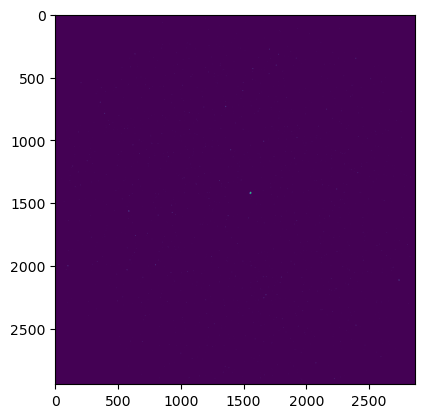

In [275]:
file_path = fd.askopenfilename(title = "Choose the position list", initialdir = base_path)
current_direct = fd.askdirectory(title = "Choose the output folder", initialdir = base_path)


pos_file = open(file_path)
data = json.load(pos_file)
POS = data['POSITIONS']

labels = [P['LABEL'] for P in POS]
posX = [P['DEVICES'][1]['X'] for P in POS]
posY = [P['DEVICES'][1]['Y'] for P in POS]


#X_c = [posX[i] for i,x in enumerate(labels) if labels[i]=='Pos287']
#Y_c = [posY[i] for i,x in enumerate(labels) if labels[i]=='Pos287']

labels_res = []
posX_res = []
posY_res = []
for i,x in enumerate(labels):
#     x = int(-850+(305-x_border)/2 + (posX[i] - 26384)/0.34) # tile 2 06/09/2022; 305 and 154 are the size of tfd 512 by 256 image
#     y = int(-385+(154-y_border)/2  - (posY[i] + 407.1)/0.34)  
#     x = int(-3967+(305-x_border)/2 + (posX[i] - 26384)/0.34) # tile 1 06/09/2022; 305 and 154 are the size of tfd 512 by 256 image
#     y = int(-405+(154-y_border)/2  - (posY[i] + 407.1)/0.34)   
#     x = int(1700+(330-x_border)/2 + (posX[i] - 27246.18)/0.34) # tile 2 19/07/2022
#     y = int(1571+(170-y_border)/2  - (posY[i] + 1149.66)/0.34)   
    x = int(deltax+(335-x_border)/2 + (posX[i] - upper_left_um_x)/0.34) # tile 2 06/09/2022;
    y = int(deltay+(150-y_border)/2  - (posY[i] - upper_left_um_y)/0.34)  # 305 and 154 are the size of tfd 512 by 256 image
#     x = int(2329+(330-x_border)/2 + (posX[i] - 28522.9)/0.34) # tile 1 19/07/2022
#     y = int(2042+(170-y_border)/2 - (posY[i] + 1313.3)/0.34) 
    if (x > 0 ) and (y > 0):
        if (y+y_border< 2944) and (x+x_border <2866) :
            labels_res.append (labels[i])
            posX_res.append (posX[i])
            posY_res.append( posY[i])


print (labels_res)

#print(usable_green_beads)
#print(usable_red_beads)
fastq_image = generate_img(y_coord,x_coord, 0, 0, max_y, max_x, 1, True, 1)
fastq_image.save(os.path.join(current_direct, 'FASTQ_image.png'))


counter = 0  

file_path = fd.askopenfilename(title = "Choose the MIN projection image", initialdir = base_path)
seq = io.imread(file_path)#reading the sequence image
seq = seq.astype("ushort") 

file_path = fd.askopenfilename(title = "Choose the MAX projection image", initialdir = base_path)
seq_max = io.imread(file_path)#reading the sequence image
seq_max = seq_max.astype("ushort")
image_array_max = np.asarray(seq_max)
good_pos = []
matched_sequences = []
matched_centers_red = []
matched_centers_green = []
matched_dist = []
processed_pos = []
FQ_shifts = []
FQ_shifts_pos = []
matched_centers_FQ = []

image_array_seq = np.asarray(seq) #array from sequence image
image_array_FQ = np.asarray(fastq_image) #array from fastq_image
beads_dir = fd.askdirectory(title = "Choose the beads folder", initialdir = base_path)
path_smFRET = fd.askdirectory(title = "Choose the smFRET folder", initialdir = base_path)
# path_smFRET = fd.askdirectory(title = "Choose the smFRET movie", initialdir = "D:/Experiments/MUSCLE DONUTS/20220824_FC_Nano_Cas9_CCR5/Cas9/green")
plt.figure()
plt.imshow(seq)
print('Number of overlapping FOVs: ',len(labels_res))

In [276]:
# Run this if you want to restart analysis from the beginning
processed_pos = []

# Main cycle. 
## Matching smFRET peaks and clusters

In [277]:
# MAIN CYCLE
os.makedirs(os.path.join(current_direct, 'QC_composites'), exist_ok=True)
os.makedirs(os.path.join(current_direct, 'QC_composites_raw'), exist_ok=True)
r = 3 # Half-width of the molecule aperture for trace extraction, i.e. for r = 3 it is -3:3
rb = 5 # Half-width of the background aperture for trace extraction 
for pos in labels_res :
#     for current_dir,dirs, files in os.walk(beads_dir) :
# #         for el in files:     
#             if el.split('.')[-2] == pos:
#     path1 = os.path.join(beads_dir,pos+'.tiff')
    path1 = os.path.join(beads_dir,pos,'A_Red_2','img_000000000.tiff')
    if os.path.exists(path1)&(not os.path.exists(os.path.join(current_direct, pos + "_traces.mat")))&(not pos in processed_pos):
#         data['sequence'] = []
        
        processed_pos.append(pos)
        pos_direct = os.path.join(current_direct, pos)
        os.makedirs(pos_direct, exist_ok=True)
        log_file = open(os.path.join(pos_direct, pos + "_log.txt"), 'w')
        log_file.write('Working on: '+ pos+'\n')
        FRET_coord = []
        seq_coord = []
        point = []
        counter = 0
        rb_rad = 10
        img_beads_F = io.imread(path1) #reading the stack of images
        if len(img_beads_F.shape) == 3:
            if img_beads_F.shape[0] == 512: # sometimes slice number is the first dimension, sometimes the third
                img_beads_F = np.mean(img_beads_F, axis = 2) #averaging by the stack
            else:
                img_beads_F = np.mean(img_beads_F, axis = 0) #averaging by the stack
             
        img_beads_F = img_beads_F.astype("ushort") #turn from float format to ushort
        img_beads_F = img_beads_F [256:512, 0:512]
        img_beads_F = img_beads_F - rolling_ball(img_beads_F, radius=rb_rad)
        image_array_F = transform.warp(img_beads_F, apriori_tr_inv, output_shape = [y_border, x_border])
        image_array_F = img_as_ubyte(image_array_F)
        #img = io.imread(current_dir + '/' + el) #initial reading of original averaging image
        #img = cv2.imread(app.st)
#         plt.figure()
#         plt.imshow(img1)
#         plt.figure()
#         plt.imshow(seq)

        image_array_F = np.asarray(image_array_F) #array from FRET image
#         plt.figure()
#         plt.imshow(image_array_F)
        
        idx = [i for i,x in enumerate(labels_res) if labels_res[i]==pos]
#                 X_c = [posX_res[i] for i,x in enumerate(labels_res) if labels_res[i]==pos]
#                 Y_c = [posY_res[i] for i,x in enumerate(labels_res) if labels_res[i]==pos]
        X_c = [posX_res[i] for i in idx]
        Y_c = [posY_res[i] for i in idx]

        X_c, Y_c = scaling_seq(X_c[0], Y_c[0])
#         print (X_c, Y_c)
        point.append(X_c)
        point.append(Y_c)
        point = np.array(point)
        image_array_seq_t = image_array_seq[ Y_c:Y_c+y_border, X_c:X_c+x_border]
        image_array_max_t = image_array_max[ Y_c:Y_c+y_border, X_c:X_c+x_border]
        image_array_FQ_t = image_array_FQ[ Y_c:Y_c+y_border, X_c:X_c+x_border]
        idx = [i for i,x in enumerate(x_coord) if x_coord[i] >= X_c and (x_coord[i] <= X_c+x_border) and (y_coord[i] >= Y_c) and (y_coord[i] <= Y_c+y_border)]
        x_FQ = [x_coord[i] for i in idx]
        y_FQ = [y_coord[i] for i in idx]
        seq_t = [sequence[i] for i in idx]
        if len(seq_t)<100:
            log_file.write('Not enough (<100) clusters: '+ str(len(seq_t))+ '\n')
            continue

        #print(image_array)

        #reading by cv2 to make possible circles in color
        #img_jpg = io.imread('C:/Users/panf/Documents/Muscle_intermediates/AVG_G10_1_1_MMStack_Pos0.ome.jpg')
        #img_array = img_as_int(img)
        # displaying the image
        # setting mouse handler for the image
        # and calling the click_event() function
        image_seq = Image.fromarray(image_array_seq_t)
        image_seq.save (pos_direct + '/'+ pos+'_seq.tif')

        image_fastq = Image.fromarray(image_array_FQ_t)
        image_fastq.save (pos_direct + '/'+ pos+'_fastq.tif')

        v_min, v_max = np.percentile(image_array_seq_t, (0, 99.8))
        if v_max == 0: v_max = np.max(image_array_seq_t)  

        # Calculating the shift between the FASTQ and cluster images using cross-correlation
        shift = phase_cross_correlation(image_array_max_t,image_array_FQ_t)
        shift = shift[0]
        print(shift)
        # Translation of the FASTQ sequences in the FOV to match the cluster image
        x_FQ = np.subtract(x_FQ,X_c-shift[1])
        y_FQ = np.subtract(y_FQ,Y_c-shift[0])
        FQ_shifts.append([X_c-shift[1], Y_c-shift[0]])
        FQ_shifts_pos.append(pos)
        
        MAX_centers = blob_detection(
            image_array_max_t,
            min_sigma=1,
            max_sigma=10,
            threshold=0.0001
        )
        FQ_centers_all = np.concatenate((x_FQ, y_FQ)).reshape((-1, 2), order='F')
        res, idx = count_nearest_pts(FQ_centers_all, MAX_centers, 2)
        FQ_centers_all1 = FQ_centers_all[idx[np.where(res != inf)]]
        MAX_centers1 = MAX_centers[np.where(res != inf)]
#         print(FQ_centers_all1)
#         print(MAX_centers1)

        trFQtoMAX = transform.estimate_transform("similarity", src=FQ_centers_all1, dst=MAX_centers1)

        temp = trFQtoMAX(FQ_centers_all)
        x_FQ = temp[:,0];
        y_FQ = temp[:,1];

        fastq_image1 = generate_img(y_FQ,x_FQ, 0, 0, y_border, x_border, 1, True, 1)
        fastq_image1.save(os.path.join(pos_direct,pos+'_FQ_aligned.png'))
        max_image = generate_img(MAX_centers[:,1],MAX_centers[:,0], 0, 0, y_border, x_border, 1, True, 1)
        max_image.save(os.path.join(pos_direct,pos+'_MAX_seq_CoM.png'))
        max_image = Image.fromarray(image_array_max_t)
        max_image.save(os.path.join(pos_direct,pos+'_MAX_seq.png'))
#         fastq_image1 = generate_img(y_FQ,x_FQ, 0, 0, y_border, x_border, 1, True, 1)
#         fastq_image1.save(os.path.join(pos_direct,pos+'_FQ_aligned.png'))
        fig, ax = plt.subplots()
        ax.imshow(fastq_image1)
        plt.show()

        # Selecting the library sequences for further analysis
        idx = [i for i,x in enumerate(seq_t) if library_seq in x]
        x_FQ = [x_FQ[i] for i in idx]
        y_FQ = [y_FQ[i] for i in idx]
        seq_t = [seq_t[i] for i in idx]

        # Calculating the transformation based on automatically-selected beads
        movie_centers = blob_detection(
            np.asarray(img_beads_F),
            min_sigma=1,
            max_sigma=10,
            threshold=0.05 #230703 was 0.003
        )

        seq_centers = blob_detection(
            image_array_seq_t,
            min_sigma=1,
            max_sigma=10,
            threshold=0.001, # Was 0.00001 for 19/07/2022 and 0.0005
         )
        
        if len(movie_centers)> 2: 
            a = run(seq_centers, apriori_tr(movie_centers))
        else:
            log_file.write("""Not enough (<3) automatically detected beads to update the initial
                           transformation estimate based on manually selected beads\n""")
            continue
    
        uknmatchstars_coord = []
        refmatchstars_coord = []
        if len(a[0].refmatchstars) >= 3:
            for i in range (len(a[0].refmatchstars)):
                uknmatchstars_coord.append(a[0].uknmatchstars[i].x)
                uknmatchstars_coord.append(a[0].uknmatchstars[i].y)
                refmatchstars_coord.append(a[0].refmatchstars[i].x)
                refmatchstars_coord.append(a[0].refmatchstars[i].y)

            refmatchstars_coord = np.array(refmatchstars_coord)
            uknmatchstars_coord = np.array(uknmatchstars_coord)

            refmatchstars_coord = np.reshape ( refmatchstars_coord, ( int(len(a[0].refmatchstars)), 2 ) )
            uknmatchstars_coord = np.reshape ( uknmatchstars_coord, ( int(len(a[0].uknmatchstars)), 2 ) )
            result_coord = np.concatenate ((refmatchstars_coord,uknmatchstars_coord ), axis = 0)
#             print (pos+"\n", result_coord )
            np.save (os.path.join(pos_direct, pos + "_matching_beads"), result_coord)
        else:
            log_file.write("""Not enough (<3) automatically detected and matched beads to update the initial
                           transformation estimate based on manually selected beads\n""")
            continue
#         res, idx = count_nearest_pts(rough_tr(movie_centers), seq_centers, 8)
#         movie_centers1 = movie_centers[idx[np.where(res != inf)]]
#         seq_centers1 = seq_centers[np.where(res != inf)]
        movie_centers1 = apriori_tr_inv(uknmatchstars_coord)
        seq_centers1 = refmatchstars_coord
        print('Automatically matched beads: ',seq_centers1.shape[0])
        rough_tr1 = transform.estimate_transform("similarity", src=movie_centers1, dst=seq_centers1)
        np.save(os.path.join(pos_direct, pos + "_auto_bead_tr"), rough_tr1)
        # Reading the smFRET movie
#             path_smFRET_file = os.path.join(path_smFRET,pos+'.tiff')
        if os.path.exists(os.path.join(path_smFRET,pos,'B_Green','img_000000000.tiff')):
            path_smFRET_file = os.path.join(path_smFRET,pos,'B_Green','img_000000000.tiff')
        elif os.path.exists(os.path.join(path_smFRET,pos,'B_hairpinGreen','img_000000000.tiff')):
            path_smFRET_file = os.path.join(path_smFRET,pos,'B_hairpinGreen','img_000000000.tiff')
        elif os.path.exists(os.path.join(path_smFRET,pos,'B_Green_hairpin','img_000000000.tiff')):
            path_smFRET_file = os.path.join(path_smFRET,pos,'B_Green_hairpin','img_000000000.tiff')
        else:
            continue

        img_smFRET = io.imread(path_smFRET_file)

        # Averaging the first 10 frames to select peaks
        if ALEX:
            img_t = np.mean(img_smFRET[green_frames,::], axis = 0)
        else:
            img_t = np.mean(img_smFRET[0:10,::], axis = 0)
        img_t = img_t.astype("ushort")
        rb_rad = 10

        red = img_t[256:,:]
        green = img_t[:256,:]
        red = red - rolling_ball(red, radius=rb_rad)
        green = green - rolling_ball(green, radius=rb_rad)
        green = transform.warp(green,tr_R2G, preserve_range = True)
        #combined = red + green # Consider adding the red excitation channel, though there are some difficulties, e.g. beads and int scaling
        combined = red 
        fig, ax = plt.subplots()
        ax.imshow(combined)
        blobs_log = blob_log(combined, max_sigma=10, num_sigma=10, threshold=0.02) # Was 1000 for 19/07/2022
#             Was 300 for 06/09/2022
        CM = []
        r = 3
        [h,w] = red.shape
        n_frames = img_smFRET.shape[0]

        for i, blob in enumerate(blobs_log):
            x, y, d = blob
            if x>r and x<(h-r) and y>r and y<(w-r):
                temp = ndimage.measurements.center_of_mass(combined[int(x-r):int(x+r+1),int(y-r):int(y+r+1)])
                CM.append(np.flip(np.add(temp, [x-r,y-r])))

                c = plt.Circle(CM[-1], 3, color="red", linewidth=1, fill=False)
                ax.add_patch(c)
        ax.set_axis_off()
        plt.savefig(os.path.join(pos_direct, pos + "_smFRET_peaks.tif"))
        plt.show()


        smFRET_centers = np.array(CM)
        FQ_centers = np.concatenate((x_FQ, y_FQ)).reshape((-1, 2), order='F')
        res, idx = count_nearest_pts(rough_tr1(smFRET_centers), FQ_centers, 2)
        movie_centers1 = smFRET_centers[idx[np.where(res != inf)]]
        seq_centers1 = FQ_centers[np.where(res != inf)]

        if seq_centers1.shape[0]<4:
            print('Not enough smFRET peaks (<4)')
            log_file.write('Not enough smFRET peaks (<4)')
            continue

        tr = transform.estimate_transform("similarity", src=movie_centers1, dst=seq_centers1)
        tr_inv = transform.estimate_transform("similarity", src=seq_centers1, dst=movie_centers1)
        np.save(os.path.join(pos_direct, pos + "_final_tr"), tr)
        np.save(os.path.join(pos_direct, pos + "_final_tr_inv"), tr_inv)
        log_file.write('Matched clusters before transform update: ' + str(seq_centers1.shape[0])+'\n')
        print('Matched clusters before transform update: ',seq_centers1.shape[0])

        res, idx = count_nearest_pts(tr(smFRET_centers), FQ_centers, 3) # Was 4 for 19/07/2022
        centers_matched = smFRET_centers[idx[np.where(res != inf)]]
        idx_t = np.where(res != inf)
        seq_matched = [seq_t[i] for i in idx_t[0]]
        FQ_centers_matched = FQ_centers[idx_t]
        distances_matched = res[idx_t]

        centers_red = centers_matched
        centers_green = tr_R2G(centers_matched)
        r = 3
        # Weed out positions that are too close to the edge
        idx_t = np.where((centers_red[:,0]>rb) & (centers_red[:,0]<(w-rb)) & (centers_red[:,1]>rb) & (centers_red[:,1]<(h-rb))  & 
                         (centers_green[:,0]>rb) & (centers_green[:,0]<(w-rb)) & (centers_green[:,1]>rb) & (centers_green[:,1]<(h-rb)))
        centers_red = centers_red [idx_t]
        centers_green = centers_green [idx_t]
        distances_matched = distances_matched[idx_t]
        seq_matched = [seq_matched[i] for i in idx_t[0]]

        matched_sequences.append(seq_matched)
        matched_centers_red.append(centers_red)
        matched_centers_green.append(centers_green)
        matched_dist.append(distances_matched)
        matched_centers_FQ.append(FQ_centers_matched)
        good_pos.append(pos)
        log_file.write('Matched clusters after transform update: ' + str(len(seq_matched))+'\n')
        log_file.write('Out of ' + str(len(smFRET_centers)) + ' smFRET peaks and ' + str(len(FQ_centers)) + ' clusters'+'\n')
        log_file.write('Percentage of matched smFRET peaks: ' + str(int(100*len(seq_matched)/len(smFRET_centers)))+'\n')
        log_file.write('Percentage of matched clusters: ' + str(int(100*len(seq_matched)/len(FQ_centers)))+'\n')
        print('Matched clusters after transform update: ',len(seq_matched))
        print('Out of ',len(smFRET_centers), ' smFRET peaks and ', len(FQ_centers), ' clusters')
        print('Percentage of matched smFRET peaks: ',int(100*len(seq_matched)/len(smFRET_centers)))
        print('Percentage of matched clusters: ',int(100*len(seq_matched)/len(FQ_centers)))
        # Saving transformed bead and molecule images for QC
        img_beads_tfd = Image.fromarray(transform.warp(img_beads_F, tr_inv, output_shape = [y_border, x_border]))
        img_beads_tfd.save(os.path.join(pos_direct, pos + "_beads_transformed.tif"))
        img_smFRET_tfd = Image.fromarray(transform.warp(combined, tr_inv, output_shape = [y_border, x_border]))
        img_smFRET_tfd.save(os.path.join(pos_direct, pos + "_smFRET_transformed.tif"))
        centers_red_tfd = tr(centers_red)
        img_centers_red_tfd = generate_img(centers_red_tfd[:,1],centers_red_tfd[:,0], 0, 0, y_border, x_border, 1, True, 1)
        img_centers_red_tfd.save(os.path.join(pos_direct, pos + "_smFRET_peaks_matched_transformed.tif"))

        centers_red_tfd = tr(smFRET_centers)
        img_centers_red_tfd = generate_img(centers_red_tfd[:,1],centers_red_tfd[:,0], 0, 0, y_border, x_border, 1, True, 1)
        img_centers_red_tfd.save(os.path.join(pos_direct, pos + "_smFRET_peaks_all_transformed.tif"))

        img_centers_red_tfd = generate_img(FQ_centers_matched[:,1],FQ_centers_matched[:,0], 0, 0, y_border, x_border, 1, True, 1)
        img_centers_red_tfd.save(os.path.join(pos_direct, pos + "_FQ_lib_matched.tif"))

        img_centers_red_tfd = generate_img(FQ_centers[:,1],FQ_centers[:,0], 0, 0, y_border, x_border, 1, True, 1)
        img_centers_red_tfd.save(os.path.join(pos_direct, pos + "_FQ_lib_all.tif"))
        
#         Saving a composite image for quick QC
        fig, ax = plt.subplots()
        QC_composite_array = np.zeros([y_border,x_border,3], dtype=np.uint8)
        red_channel = np.asarray(generate_img(centers_red_tfd[:,1],centers_red_tfd[:,0], 0, 0, y_border, x_border, 1, True, 1))
        percentiles = np.percentile(red_channel[75:125,:], (0.5, 99.5))        
        red_channel = exposure.rescale_intensity(red_channel, in_range=tuple(percentiles))
        red_channel = img_as_ubyte(red_channel)

        green_channel = np.asarray(generate_img(FQ_centers[:,1],FQ_centers[:,0], 0, 0, y_border, x_border, 1, True, 1))
        percentiles = np.percentile(green_channel, (0.5, 99.5))
        green_channel = exposure.rescale_intensity(green_channel, in_range=tuple(percentiles))
        green_channel = img_as_ubyte(green_channel)

        blue_channel = np.asarray(generate_img(FQ_centers_matched[:,1],FQ_centers_matched[:,0], 0, 0, y_border, x_border, 1, True, 1))
        percentiles = np.percentile(blue_channel, (0.5, 99.5))
        blue_channel = exposure.rescale_intensity(blue_channel, in_range=tuple(percentiles))
        blue_channel = img_as_ubyte(blue_channel)

        QC_composite_array[:,:,0] = red_channel
        QC_composite_array[:,:,1] = green_channel
        QC_composite_array[:,:,2] = blue_channel

        QC_composite = Image.fromarray(QC_composite_array, mode="RGB")
        QC_composite.save(os.path.join(current_direct, 'QC_composites_raw' , pos + "_QC.tif"))

        ax.imshow(QC_composite)
        for blob in FQ_centers_matched:
            c = plt.Circle(blob, 3, color="red", linewidth=1, fill=False)
            ax.add_patch(c)
        ax.set_axis_off()
        plt.savefig(os.path.join(current_direct, 'QC_composites' , pos + "_QC.png"))
        plt.show()
        

# Save good pos data to be able to extract traces later
frame_rate = 5
mdict1 = {
    "good_pos": good_pos,
    "matched_sequences": matched_sequences,
    "matched_centers_red": matched_centers_red,
    "matched_centers_green": matched_centers_green,
    "matched_distances": matched_dist,
    "matched_FASTQ": matched_centers_FQ,
    "FASTQ_shifts": FQ_shifts
}

savemat(os.path.join(current_direct, "good_pos.mat"), mdict1)


In [256]:
print('Number of matched FOVs: ',len(good_pos))

Number of matched FOVs:  0


## Extracting traces with median background estimation

In [239]:
# Extracting traces, median BG version
r = 3 # Half-width of the molecule aperture for trace extraction, i.e. for r = 3 it is -3:3
rb = 5 # Half-width of the background aperture for trace extraction 
# (bacground is calculated as a median of intensities in a rectangular aperture between r and rb)
# a = np.subtract(range(2*rb+1), rb)
at = [[j,i] for i in range(2*rb+1) for j in range(rb-r)]
bt = [[j,i] for i in range(2*rb+1) for j in range(r+rb+1,2*rb+1)]
ct = [[j,i] for i in range(rb-r) for j in range(rb-r,r+rb+1)]
dt = [[j,i] for i in range(r+rb+1,2*rb+1) for j in range(rb-r,r+rb+1)]
idx_bg = np.subtract(np.concatenate([at,bt,ct,dt]), [rb,rb]) # Indexes that define the background aperture

for i, pos in enumerate(good_pos):
    # Reading the smFRET movie
    if os.path.exists(os.path.join(path_smFRET,pos,'B_Green','img_000000000.tiff')):
        path_smFRET_file = os.path.join(path_smFRET,pos,'B_Green','img_000000000.tiff')
    elif os.path.exists(os.path.join(path_smFRET,pos,'B_hairpinGreen','img_000000000.tiff')):
        path_smFRET_file = os.path.join(path_smFRET,pos,'B_hairpinGreen','img_000000000.tiff')
    elif os.path.exists(os.path.join(path_smFRET,pos,'B_Green_hairpin','img_000000000.tiff')):
        path_smFRET_file = os.path.join(path_smFRET,pos,'B_Green_hairpin','img_000000000.tiff')
    else:
        continue
    img_smFRET = io.imread(path_smFRET_file)
    

    seq_matched = matched_sequences[i]
    dist_matched = matched_dist[i]
    centers_red = matched_centers_red[i]
    centers_green = matched_centers_green[i]
    n_traces = len(centers_red)
    [h,w] = [256,512]
    n_frames = img_smFRET.shape[0]

    weights_red = np.zeros([n_traces,2*r+1,2*r+1])
    weights_green = np.zeros([n_traces,2*r+1,2*r+1])
    traces_red =  np.zeros([n_traces,n_frames])
    traces_green = np.zeros([n_traces,n_frames])
    # Extracting the traces from matched smFRET peaks
    # Extracting the traces from matched smFRET peaks
    # Select matching peaks from peak_locations and their sequences


    for j,coord in enumerate(centers_red):
        x, y = coord
        x0 = int(x-r)
        x1 = int(x+r+1)
        y0 = int(y-r)
        y1 = int(y+r+1)
        dx = x-x0
        dy = y-y0

        it = np.nditer(weights_red[j], flags=['multi_index'], op_flags=['readwrite'])
        for w1 in it:
            yt,xt = it.multi_index
            w1[...] = 2*exp(-0.4*((xt-dx)**2+(yt-dy)**2))
        it.close()

        x, y = centers_green[j]
        x0 = int(x-r)
        x1 = int(x+r+1)
        y0 = int(y-r)
        y1 = int(y+r+1)
        dx = x-x0
        dy = y-y0

        it = np.nditer(weights_green[j], flags=['multi_index'], op_flags=['readwrite'])
        for w1 in it:
            yt,xt = it.multi_index
            w1[...] = 2*exp(-0.4*((xt-dx)**2+(yt-dy)**2))
        it.close()

    for i in range(n_frames):
        if i%100 == 0: print("Working on frame "+str(i))
        red1 = img_smFRET[i,256:,:]
        red1 = red1 - si.restoration.rolling_ball(red1, radius=rb_rad)
        green1 = img_smFRET[i,:256,:]
        green1 = green1 - si.restoration.rolling_ball(green1, radius=rb_rad)

        for j,coord in enumerate(centers_red):
            x, y = coord
            x0 = int(x-r)
            x1 = int(x+r+1)
            y0 = int(y-r)
            y1 = int(y+r+1)
            dx = x-x0
            dy = y-y0
#             red2 = red1[y0:y1,x0:x1]
#             traces_red[j,i] = np.sum(np.multiply(weights_red[j],red2))

            index = np.add(idx_bg,[int(x), int(y)])
            # Temporary fix for molecules that are too close to the edge
#             if (np.max(index[:,1])<256)&(np.min(index[:,1])>=0)&(np.max(index[:,0])<512)&(np.min(index[:,0])>=0):            
            BG = np.median(red1[index[:,1], index[:,0]])
            red2 = np.subtract(red1[y0:y1,x0:x1], BG)
            traces_red[j,i] = np.sum(np.multiply(weights_red[j],red2))
#             else:
#                 traces_red[j,i] = -10000
                
            x, y = centers_green[j]
            x0 = int(x-r)
            x1 = int(x+r+1)
            y0 = int(y-r)
            y1 = int(y+r+1)
            dx = x-x0
            dy = y-y0
#             green2 = green1[y0:y1,x0:x1]
#             traces_green[j,i] = np.sum(np.multiply(weights_green[j],green2))
            index = np.add(idx_bg,[int(x), int(y)])
#             if (np.max(index[:,1])<256)&(np.min(index[:,1])>=0)&(np.max(index[:,0])<512)&(np.min(index[:,0])>=0):            
            BG = np.median(green1[index[:,1], index[:,0]])
            green2 = np.subtract(green1[y0:y1,x0:x1], BG)
            traces_green[j,i] = np.sum(np.multiply(weights_green[j],green2))
#             else:
#                 traces_green[j,i] = -10000
            


    # Save traces and sequences
    frame_rate = 5
    mdict = {
        "time": np.divide(range(n_frames),frame_rate),
        "Cy3": traces_green,
        "Cy5": traces_red,
        "Seq": seq_matched,
        "Dist": dist_matched,
        "x": centers_red[:,0],
        "y": centers_red[:,1],
        "x_FQ": centers_FQ[:,0],
        "y_FQ": centers_FQ[:,1]
    }

    savemat(os.path.join(current_direct, pos + "_traces.mat"), mdict)

Working on frame 0
Working on frame 100
Working on frame 0
Working on frame 100
Working on frame 0
Working on frame 100
Working on frame 0
Working on frame 100
Working on frame 0
Working on frame 100
Working on frame 0
Working on frame 100
Working on frame 0
Working on frame 100
Working on frame 0
Working on frame 100
Working on frame 0
Working on frame 100
Working on frame 0
Working on frame 100
Working on frame 0
Working on frame 100
Working on frame 0
Working on frame 100
Working on frame 0
Working on frame 100
Working on frame 0
Working on frame 100
Working on frame 0
Working on frame 100
Working on frame 0
Working on frame 100
Working on frame 0
Working on frame 100
Working on frame 0
Working on frame 100
Working on frame 0
Working on frame 100
Working on frame 0
Working on frame 100
Working on frame 0
Working on frame 100
Working on frame 0
Working on frame 100
Working on frame 0
Working on frame 100
Working on frame 0
Working on frame 100
Working on frame 0
Working on frame 100


## Manual bead selection

In [240]:
processed_pos = []

[-39. -91.]


/var/folders/b2/54gcqwj950g58b830dq8jhwh0000gn/T/ipykernel_12436/1823133743.py:208: DeprecationWarning: Please use `center_of_mass` from the `scipy.ndimage` namespace, the `scipy.ndimage.measurements` namespace is deprecated.
  ndimage.measurements.center_of_mass(


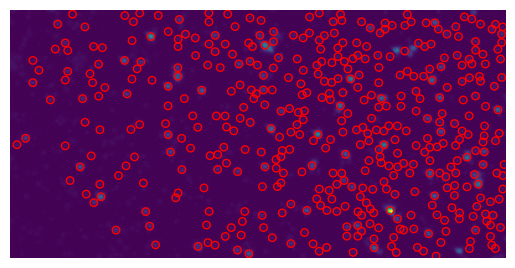

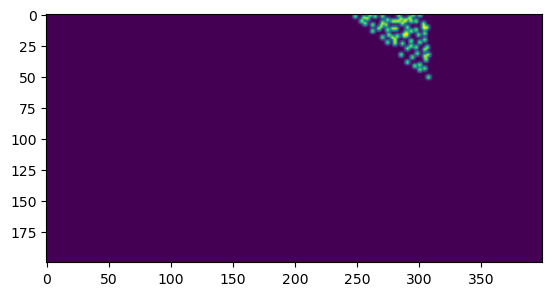

/var/folders/b2/54gcqwj950g58b830dq8jhwh0000gn/T/ipykernel_12436/3817313015.py:258: DeprecationWarning: Please use `center_of_mass` from the `scipy.ndimage` namespace, the `scipy.ndimage.measurements` namespace is deprecated.
  temp = ndimage.measurements.center_of_mass(combined[int(x-r):int(x+r+1),int(y-r):int(y+r+1)])


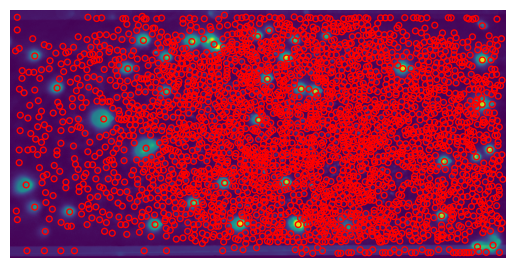

Matched clusters before transform update:  4
Matched clusters after transform update:  4
Out of  2690  smFRET peaks and  15  clusters
Percentage of matched smFRET peaks:  0
Percentage of matched clusters:  26


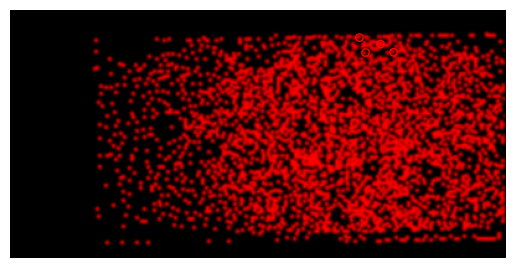

[12. -6.]


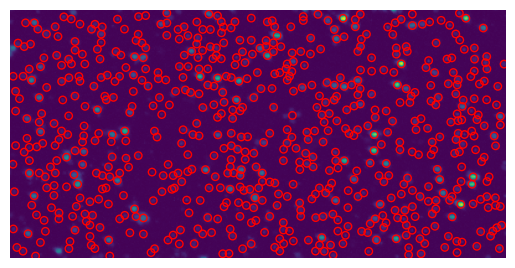

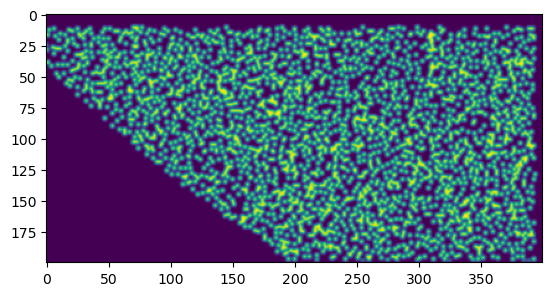

KeyboardInterrupt: 

In [180]:
# MAIN CYCLE WITH MANUAL BEAD SELECTION
good_pos = []
matched_sequences = []
matched_centers_red = []
matched_centers_green = []
matched_dist = []
FQ_shifts = []
FQ_shifts_pos = []
matched_centers_FQ = []
# processed_pos = []
os.makedirs(os.path.join(current_direct, 'QC_composites'), exist_ok=True)
os.makedirs(os.path.join(current_direct, 'QC_composites_raw'), exist_ok=True)
r = 3 # Half-width of the molecule aperture for trace extraction, i.e. for r = 3 it is -3:3
rb = 5 # Half-width of the background aperture for trace extraction 
for pos in labels_res :
#     for current_dir,dirs, files in os.walk(beads_dir) :
# #         for el in files:     
#             if el.split('.')[-2] == pos:
#     path1 = os.path.join(beads_dir,pos+'.tiff')
    path1 = os.path.join(beads_dir,pos,'A_Red_2','img_000000000.tiff')
    if os.path.exists(path1)&(not os.path.exists(os.path.join(current_direct, pos + "_traces.mat")))&(not pos in processed_pos):
#         data['sequence'] = []
        
        processed_pos.append(pos)
        pos_direct = os.path.join(current_direct, pos)
        os.makedirs(pos_direct, exist_ok=True)
        log_file = open(os.path.join(pos_direct, pos + "_log.txt"), 'w')
        log_file.write('Working on: '+ pos+'\n')
        FRET_coord = []
        seq_coord = []
        point = []
        counter = 0
        rb_rad = 10
        img_beads_F = io.imread(path1) #reading the stack of images
        
        if len(img_beads_F.shape) == 3:
            if img_beads_F.shape[0] == 512: # sometimes slice number is the first dimension, sometimes the third
                img_beads_F = np.mean(img_beads_F, axis = 2) #averaging by the stack
            else:
                img_beads_F = np.mean(img_beads_F, axis = 0) #averaging by the stack
        
        img_beads_F = img_beads_F.astype("ushort") #turn from float format to ushort
        img_beads_F = img_beads_F [256:512, 0:512]
        img_beads_F = img_beads_F - rolling_ball(img_beads_F, radius=rb_rad)
        image_array_F = transform.warp(img_beads_F, apriori_tr_inv, output_shape = [y_border, x_border])
        image_array_F = img_as_ubyte(image_array_F)
        #img = io.imread(current_dir + '/' + el) #initial reading of original averaging image
        #img = cv2.imread(app.st)
#         plt.figure()
#         plt.imshow(img1)
#         plt.figure()
#         plt.imshow(seq)

        image_array_F = np.asarray(image_array_F) #array from FRET image
#         plt.figure()
#         plt.imshow(image_array_F)
        
        idx = [i for i,x in enumerate(labels_res) if labels_res[i]==pos]
#                 X_c = [posX_res[i] for i,x in enumerate(labels_res) if labels_res[i]==pos]
#                 Y_c = [posY_res[i] for i,x in enumerate(labels_res) if labels_res[i]==pos]
        X_c = [posX_res[i] for i in idx]
        Y_c = [posY_res[i] for i in idx]

        X_c, Y_c = scaling_seq(X_c[0], Y_c[0])
#         print (X_c, Y_c)
        point.append(X_c)
        point.append(Y_c)
        point = np.array(point)
        image_array_seq_t = image_array_seq[ Y_c:Y_c+y_border, X_c:X_c+x_border]
        image_array_max_t = image_array_max[ Y_c:Y_c+y_border, X_c:X_c+x_border]
        image_array_FQ_t = image_array_FQ[ Y_c:Y_c+y_border, X_c:X_c+x_border]
        idx = [i for i,x in enumerate(x_coord) if x_coord[i] >= X_c and (x_coord[i] <= X_c+x_border) and (y_coord[i] >= Y_c) and (y_coord[i] <= Y_c+y_border)]
        x_FQ = [x_coord[i] for i in idx]
        y_FQ = [y_coord[i] for i in idx]
        seq_t = [sequence[i] for i in idx]
        if len(seq_t)<100:
            log_file.write('Not enough (<100) clusters: '+ str(len(seq_t))+ '\n')
            continue

        #print(image_array)

        #reading by cv2 to make possible circles in color
        #img_jpg = io.imread('C:/Users/panf/Documents/Muscle_intermediates/AVG_G10_1_1_MMStack_Pos0.ome.jpg')
        #img_array = img_as_int(img)
        # displaying the image
        # setting mouse handler for the image
        # and calling the click_event() function
        image_seq = Image.fromarray(image_array_seq_t)
        image_seq.save (pos_direct + '/'+ pos+'_seq.tif')

        image_fastq = Image.fromarray(image_array_FQ_t)
        image_fastq.save (pos_direct + '/'+ pos+'_fastq.tif')

        v_min, v_max = np.percentile(image_array_seq_t, (0, 99.8))
        if v_max == 0: v_max = np.max(image_array_seq_t)  

        # Calculating the shift between the FASTQ and cluster images using cross-correlation
        shift = phase_cross_correlation(image_array_max_t,image_array_FQ_t)
        shift = shift[0]
        print(shift)
        # Translation of the FASTQ sequences in the FOV to match the cluster image
        x_FQ = np.subtract(x_FQ,X_c-shift[1])
        y_FQ = np.subtract(y_FQ,Y_c-shift[0])
        
        MAX_centers = blob_detection(
            image_array_max_t,
            min_sigma=1,
            max_sigma=10,
            threshold=0.0001
        )
        FQ_centers_all = np.concatenate((x_FQ, y_FQ)).reshape((-1, 2), order='F')
        res, idx = count_nearest_pts(FQ_centers_all, MAX_centers, 2)
        FQ_centers_all1 = FQ_centers_all[idx[np.where(res != inf)]]
        MAX_centers1 = MAX_centers[np.where(res != inf)]
#         print(FQ_centers_all1)
#         print(MAX_centers1)

        trFQtoMAX = transform.estimate_transform("similarity", src=FQ_centers_all1, dst=MAX_centers1)

        temp = trFQtoMAX(FQ_centers_all)
        x_FQ = temp[:,0];
        y_FQ = temp[:,1];

        fastq_image1 = generate_img(y_FQ,x_FQ, 0, 0, y_border, x_border, 1, True, 1)
        fastq_image1.save(os.path.join(pos_direct,pos+'_FQ_aligned.png'))
        max_image = generate_img(MAX_centers[:,1],MAX_centers[:,0], 0, 0, y_border, x_border, 1, True, 1)
        max_image.save(os.path.join(pos_direct,pos+'_MAX_seq_CoM.png'))
        max_image = Image.fromarray(image_array_max_t)
        max_image.save(os.path.join(pos_direct,pos+'_MAX_seq.png'))
#         fastq_image1 = generate_img(y_FQ,x_FQ, 0, 0, y_border, x_border, 1, True, 1)
#         fastq_image1.save(os.path.join(pos_direct,pos+'_FQ_aligned.png'))
        fig, ax = plt.subplots()
        ax.imshow(fastq_image1)
        plt.show()

        # Selecting the library sequences for further analysis
        idx = [i for i,x in enumerate(seq_t) if library_seq in x]
        x_FQ = [x_FQ[i] for i in idx]
        y_FQ = [y_FQ[i] for i in idx]
        seq_t = [seq_t[i] for i in idx]

        

        v_min, v_max = np.percentile(image_array_F, (0, 100))
        if v_max == 0: v_max = np.max(image_array_F)
        v_max = 0.1*v_max #adjust the percent (10% in this run) as necessary
        better_contrast_image_array = exposure.rescale_intensity(image_array_F, in_range=(v_min, v_max))
        better_contrast_img = Image.fromarray(better_contrast_image_array)
        better_contrast_img.save(pos_direct + '/'+pos + '_contr.tif')
        better_contrast_img = cv2.imread(pos_direct + '/'+pos + '_contr.tif')
        #reading by cv2 to make possible circles in color
        v_min, v_max = np.percentile(image_array_seq_t, (0, 100))
        if v_max == 0: v_max = np.max(image_array_seq_t)
        v_max = 0.1*v_max
        better_contrast_image_array_2 = exposure.rescale_intensity(image_array_seq_t, in_range=(v_min, v_max))
        better_contrast_img_2 = Image.fromarray(better_contrast_image_array_2)
        better_contrast_img_2.save(pos_direct + '/'+''+ pos+'_contr_MIN_seq_stack.tif')
        better_contrast_img_2 = cv2.imread(pos_direct + '/'+pos+ '_contr_MIN_seq_stack.tif') 
        FRET_coord = []
        seq_coord = []
#         cv2.namedWindow(pos) 
#         cv2.namedWindow(pos+'_seq') 
        cv2.namedWindow(pos, cv2.WINDOW_NORMAL) 
        cv2.namedWindow(pos+'_seq',cv2.WINDOW_NORMAL) 

        cv2.setMouseCallback(pos,  click_event_FRET)
        cv2.setMouseCallback(pos+'_seq',  click_event_seq)
        cv2.resizeWindow(pos, 2*x_border,2*y_border)
        cv2.resizeWindow(pos+'_seq', 2*x_border,2*y_border)
        #cv2.setMouseCallback('image1',  click_event)
        while(1):
            cv2.imshow(pos,better_contrast_img)
            cv2.imshow(pos+'_seq',better_contrast_img_2)
            k = cv2.waitKey(1)&0xFF 
            #if cv2.waitKey(20) & 0xFF == 27: #press Esc to quit
            if k == ord('q'): # Press 'q' to finish
                if len(seq_coord) == len(FRET_coord):
                    break
                else:
                    counter = 0
                    cv2.destroyAllWindows()
                    FRET_coord = []
                    seq_coord = []
                    cv2.namedWindow(pos, cv2.WINDOW_NORMAL) 
                    cv2.namedWindow(pos+'_seq',cv2.WINDOW_NORMAL) 
                    cv2.setMouseCallback(pos,  click_event_FRET)
                    cv2.setMouseCallback(pos+'_seq',  click_event_seq)
                    cv2.resizeWindow(pos, 2*x_border,2*y_border)
                    cv2.resizeWindow(pos+'_seq', 2*x_border,2*y_border)
                    better_contrast_img_2 = cv2.imread(pos_direct + '/'+pos+ '_contr_MIN_seq_stack.tif')
                    better_contrast_img = cv2.imread(pos_direct + '/'+pos + '_contr.tif')
            elif k == ord('r'): # Press 'r' to restart
                counter = 0
                cv2.destroyAllWindows()
                FRET_coord = []
                seq_coord = []
                cv2.namedWindow(pos, cv2.WINDOW_NORMAL) 
                cv2.namedWindow(pos+'_seq',cv2.WINDOW_NORMAL) 
                cv2.setMouseCallback(pos,  click_event_FRET)
                cv2.setMouseCallback(pos+'_seq',  click_event_seq)
                cv2.resizeWindow(pos, 2*x_border,2*y_border)
                cv2.resizeWindow(pos+'_seq', 2*x_border,2*y_border)
                better_contrast_img_2 = cv2.imread(pos_direct + '/'+pos+ '_contr_MIN_seq_stack.tif')
                better_contrast_img = cv2.imread(pos_direct + '/'+pos + '_contr.tif')
        
        cv2.destroyAllWindows()
        
        # If the user selected less than three beads we switch to the next FOV
        if len(seq_coord) < 3:
            log_file.write('Not enough (<3) manually selected beads\n')
            continue
        
        seq_coord = np.reshape(seq_coord,(int((counter+1)/2), 2))
        FRET_coord = np.reshape(FRET_coord,(int((counter+1)/2), 2))
        FRET_coord = apriori_tr_inv(FRET_coord)
        result = np.concatenate ((FRET_coord, seq_coord), axis = 0)
        np.save(pos_direct + '/' + pos+'_manual_coord', result)
        
        rough_tr1 = transform.estimate_transform("similarity", src=FRET_coord, dst=seq_coord)
        np.save(os.path.join(pos_direct, pos + "_man_bead_tr"), rough_tr1)
        # Reading the smFRET movie
#             path_smFRET_file = os.path.join(path_smFRET,pos+'.tiff')
        
        if os.path.exists(os.path.join(path_smFRET,pos,'B_Green','img_000000000.tiff')):
            path_smFRET_file = os.path.join(path_smFRET,pos,'B_Green','img_000000000.tiff')
        elif os.path.exists(os.path.join(path_smFRET,pos,'B_hairpinGreen','img_000000000.tiff')):
            path_smFRET_file = os.path.join(path_smFRET,pos,'B_hairpinGreen','img_000000000.tiff')
        elif os.path.exists(os.path.join(path_smFRET,pos,'B_Green_hairpin','img_000000000.tiff')):
            path_smFRET_file = os.path.join(path_smFRET,pos,'B_Green_hairpin','img_000000000.tiff')
        else:
            continue

        img_smFRET = io.imread(path_smFRET_file)

        # Averaging the first 10 frames to select peaks
        if ALEX:
            img_t = np.mean(img_smFRET[green_frames,::], axis = 0)
        else:
            img_t = np.mean(img_smFRET[0:10,::], axis = 0)
        img_t = img_t.astype("ushort")
        rb_rad = 10

        red = img_t[256:,:]
        green = img_t[:256,:]
        red = red - rolling_ball(red, radius=rb_rad)
        green = green - rolling_ball(green, radius=rb_rad)
        green = transform.warp(green,tr_R2G, preserve_range = True)
        combined = red + green # Consider adding the red excitation channel, though there are some difficulties, e.g. beads and int scaling
        fig, ax = plt.subplots()
        ax.imshow(combined)
        blobs_log = blob_log(combined, max_sigma=10, num_sigma=10, threshold=300) # Was 1000 for 19/07/2022
#             Was 300 for 06/09/2022
        CM = []
        r = 3
        [h,w] = red.shape
        n_frames = img_smFRET.shape[0]

        for i, blob in enumerate(blobs_log):
            x, y, d = blob
            if x>r and x<(h-r) and y>r and y<(w-r):
                temp = ndimage.measurements.center_of_mass(combined[int(x-r):int(x+r+1),int(y-r):int(y+r+1)])
                CM.append(np.flip(np.add(temp, [x-r,y-r])))

                c = plt.Circle(CM[-1], 3, color="red", linewidth=1, fill=False)
                ax.add_patch(c)
        ax.set_axis_off()
        plt.savefig(os.path.join(pos_direct, pos + "_smFRET_peaks.tif"))
        plt.show()


        smFRET_centers = np.array(CM)
        FQ_centers = np.concatenate((x_FQ, y_FQ)).reshape((-1, 2), order='F')
        res, idx = count_nearest_pts(rough_tr1(smFRET_centers), FQ_centers, 2)
        movie_centers1 = smFRET_centers[idx[np.where(res != inf)]]
        seq_centers1 = FQ_centers[np.where(res != inf)]

        if seq_centers1.shape[0]<4:
            print('Not enough smFRET peaks (<4)')
            log_file.write('Not enough smFRET peaks (<4)')
            continue

        tr = transform.estimate_transform("similarity", src=movie_centers1, dst=seq_centers1)
        tr_inv = transform.estimate_transform("similarity", src=seq_centers1, dst=movie_centers1)
        np.save(os.path.join(pos_direct, pos + "_final_tr"), tr)
        np.save(os.path.join(pos_direct, pos + "_final_tr_inv"), tr_inv)
        log_file.write('Matched clusters before transform update: ' + str(seq_centers1.shape[0])+'\n')
        print('Matched clusters before transform update: ',seq_centers1.shape[0])

        res, idx = count_nearest_pts(tr(smFRET_centers), FQ_centers, 3) # Was 4 for 19/07/2022
        centers_matched = smFRET_centers[idx[np.where(res != inf)]]
        idx_t = np.where(res != inf)
        seq_matched = [seq_t[i] for i in idx_t[0]]
        FQ_centers_matched = FQ_centers[idx_t]
        distances_matched = res[idx_t]


        centers_red = centers_matched
        centers_green = tr_R2G(centers_matched)
        r = 3
        # Weed out positions that are too close to the edge
        idx_t = np.where((centers_red[:,0]>rb) & (centers_red[:,0]<(w-rb)) & (centers_red[:,1]>rb) & (centers_red[:,1]<(h-rb))  & 
                         (centers_green[:,0]>rb) & (centers_green[:,0]<(w-rb)) & (centers_green[:,1]>rb) & (centers_green[:,1]<(h-rb)))
        centers_red = centers_red [idx_t]
        centers_green = centers_green [idx_t]
        seq_matched = [seq_matched[i] for i in idx_t[0]]
        distances_matched = distances_matched[idx_t]

        matched_sequences.append(seq_matched)
        matched_centers_red.append(centers_red)
        matched_centers_green.append(centers_green)
        matched_dist.append(distances_matched)
        matched_centers_FQ.append(FQ_centers_matched)
        
        good_pos.append(pos)
        log_file.write('Matched clusters after transform update: ' + str(len(seq_matched))+'\n')
        log_file.write('Out of ' + str(len(smFRET_centers)) + ' smFRET peaks and ' + str(len(FQ_centers)) + ' clusters'+'\n')
        log_file.write('Percentage of matched smFRET peaks: ' + str(int(100*len(seq_matched)/len(smFRET_centers)))+'\n')
        log_file.write('Percentage of matched clusters: ' + str(int(100*len(seq_matched)/len(FQ_centers)))+'\n')
        print('Matched clusters after transform update: ',len(seq_matched))
        print('Out of ',len(smFRET_centers), ' smFRET peaks and ', len(FQ_centers), ' clusters')
        print('Percentage of matched smFRET peaks: ',int(100*len(seq_matched)/len(smFRET_centers)))
        print('Percentage of matched clusters: ',int(100*len(seq_matched)/len(FQ_centers)))
        # Saving transformed bead and molecule images for QC
        img_beads_tfd = Image.fromarray(transform.warp(img_beads_F, tr_inv, output_shape = [y_border, x_border]))
        img_beads_tfd.save(os.path.join(pos_direct, pos + "_beads_transformed.tif"))
        img_smFRET_tfd = Image.fromarray(transform.warp(combined, tr_inv, output_shape = [y_border, x_border]))
        img_smFRET_tfd.save(os.path.join(pos_direct, pos + "_smFRET_transformed.tif"))
        centers_red_tfd = tr(centers_red)
        img_centers_red_tfd = generate_img(centers_red_tfd[:,1],centers_red_tfd[:,0], 0, 0, y_border, x_border, 1, True, 1)
        img_centers_red_tfd.save(os.path.join(pos_direct, pos + "_smFRET_peaks_matched_transformed.tif"))

        centers_red_tfd = tr(smFRET_centers)
        img_centers_red_tfd = generate_img(centers_red_tfd[:,1],centers_red_tfd[:,0], 0, 0, y_border, x_border, 1, True, 1)
        img_centers_red_tfd.save(os.path.join(pos_direct, pos + "_smFRET_peaks_all_transformed.tif"))

        img_centers_red_tfd = generate_img(FQ_centers_matched[:,1],FQ_centers_matched[:,0], 0, 0, y_border, x_border, 1, True, 1)
        img_centers_red_tfd.save(os.path.join(pos_direct, pos + "_FQ_lib_matched.tif"))

        img_centers_red_tfd = generate_img(FQ_centers[:,1],FQ_centers[:,0], 0, 0, y_border, x_border, 1, True, 1)
        img_centers_red_tfd.save(os.path.join(pos_direct, pos + "_FQ_lib_all.tif"))
        
#         Saving a composite image for quick QC
        fig, ax = plt.subplots()
        QC_composite_array = np.zeros([y_border,x_border,3], dtype=np.uint8)
        red_channel = np.asarray(generate_img(centers_red_tfd[:,1],centers_red_tfd[:,0], 0, 0, y_border, x_border, 1, True, 1))
        percentiles = np.percentile(red_channel[75:125,:], (0.5, 99.5))        
        red_channel = exposure.rescale_intensity(red_channel, in_range=tuple(percentiles))
        red_channel = img_as_ubyte(red_channel)

        green_channel = np.asarray(generate_img(FQ_centers[:,1],FQ_centers[:,0], 0, 0, y_border, x_border, 1, True, 1))
        percentiles = np.percentile(green_channel, (0.5, 99.5))
        green_channel = exposure.rescale_intensity(green_channel, in_range=tuple(percentiles))
        green_channel = img_as_ubyte(green_channel)

        blue_channel = np.asarray(generate_img(FQ_centers_matched[:,1],FQ_centers_matched[:,0], 0, 0, y_border, x_border, 1, True, 1))
        percentiles = np.percentile(blue_channel, (0.5, 99.5))
        blue_channel = exposure.rescale_intensity(blue_channel, in_range=tuple(percentiles))
        blue_channel = img_as_ubyte(blue_channel)

        QC_composite_array[:,:,0] = red_channel
        QC_composite_array[:,:,1] = green_channel
        QC_composite_array[:,:,2] = blue_channel

        QC_composite = Image.fromarray(QC_composite_array, mode="RGB")
        QC_composite.save(os.path.join(current_direct, 'QC_composites_raw' , pos + "_QC.tif"))

        ax.imshow(QC_composite)
        for blob in FQ_centers_matched:
            c = plt.Circle(blob, 3, color="red", linewidth=1, fill=False)
            ax.add_patch(c)
        ax.set_axis_off()
        plt.savefig(os.path.join(current_direct, 'QC_composites' , pos + "_QC.png"))
        plt.show()
        

# Save good pos data to be able to extract traces later
frame_rate = 5
mdict1 = {
    "good_pos": good_pos,
    "matched_sequences": matched_sequences,
    "matched_centers_red": matched_centers_red,
    "matched_centers_green": matched_centers_green,
    "matched_distances": matched_dist,
    "matched_FASTQ": matched_centers_FQ,
    "FASTQ_shifts": FQ_shifts
}

savemat(os.path.join(current_direct, "good_pos_man.mat"), mdict1)


In [118]:
print('Number of matched FOVs: ',len(good_pos))

Number of matched FOVs:  0


In [71]:
# Extracting traces, median BG version
r = 3 # Half-width of the molecule aperture for trace extraction, i.e. for r = 3 it is -3:3
rb = 5 # Half-width of the background aperture for trace extraction 
# (bacground is calculated as a median of intensities in a rectangular aperture between r and rb)
# a = np.subtract(range(2*rb+1), rb)
at = [[j,i] for i in range(2*rb+1) for j in range(rb-r)]
bt = [[j,i] for i in range(2*rb+1) for j in range(r+rb+1,2*rb+1)]
ct = [[j,i] for i in range(rb-r) for j in range(rb-r,r+rb+1)]
dt = [[j,i] for i in range(r+rb+1,2*rb+1) for j in range(rb-r,r+rb+1)]
idx_bg = np.subtract(np.concatenate([at,bt,ct,dt]), [rb,rb]) # Indexes that define the background aperture

for i, pos in enumerate(good_pos):
    # Reading the smFRET movie
#     img_smFRET = io.imread(os.path.join(path_smFRET,pos+'.tiff'))
    if os.path.exists(os.path.join(path_smFRET,pos,'B_Green','img_000000000.tiff')):
        path_smFRET_file = os.path.join(path_smFRET,pos,'B_Green','img_000000000.tiff')
    elif os.path.exists(os.path.join(path_smFRET,pos,'B_hairpinGreen','img_000000000.tiff')):
        path_smFRET_file = os.path.join(path_smFRET,pos,'B_hairpinGreen','img_000000000.tiff')
    elif os.path.exists(os.path.join(path_smFRET,pos,'B_Green_hairpin','img_000000000.tiff')):
        path_smFRET_file = os.path.join(path_smFRET,pos,'B_Green_hairpin','img_000000000.tiff')
    else:
        continue
    img_smFRET = io.imread(path_smFRET_file)
    
    seq_matched = matched_sequences[i]
    dist_matched = matched_dist[i]
    centers_red = matched_centers_red[i]
    centers_green = matched_centers_green[i]
    n_traces = len(centers_red)
    [h,w] = [256,512]
    n_frames = img_smFRET.shape[0]

    weights_red = np.zeros([n_traces,2*r+1,2*r+1])
    weights_green = np.zeros([n_traces,2*r+1,2*r+1])
    traces_red =  np.zeros([n_traces,n_frames])
    traces_green = np.zeros([n_traces,n_frames])
    # Extracting the traces from matched smFRET peaks
    # Extracting the traces from matched smFRET peaks
    # Select matching peaks from peak_locations and their sequences


    for j,coord in enumerate(centers_red):
        x, y = coord
        x0 = int(x-r)
        x1 = int(x+r+1)
        y0 = int(y-r)
        y1 = int(y+r+1)
        dx = x-x0
        dy = y-y0

        it = np.nditer(weights_red[j], flags=['multi_index'], op_flags=['readwrite'])
        for w1 in it:
            yt,xt = it.multi_index
            w1[...] = 2*exp(-0.4*((xt-dx)**2+(yt-dy)**2))
        it.close()

        x, y = centers_green[j]
        x0 = int(x-r)
        x1 = int(x+r+1)
        y0 = int(y-r)
        y1 = int(y+r+1)
        dx = x-x0
        dy = y-y0

        it = np.nditer(weights_green[j], flags=['multi_index'], op_flags=['readwrite'])
        for w1 in it:
            yt,xt = it.multi_index
            w1[...] = 2*exp(-0.4*((xt-dx)**2+(yt-dy)**2))
        it.close()

    for i in range(n_frames):
        if i%100 == 0: print("Working on frame "+str(i))
        red1 = img_smFRET[i,256:,:]
        red1 = red1 - si.restoration.rolling_ball(red1, radius=rb_rad)
        green1 = img_smFRET[i,:256,:]
        green1 = green1 - si.restoration.rolling_ball(green1, radius=rb_rad)

        for j,coord in enumerate(centers_red):
            x, y = coord
            x0 = int(x-r)
            x1 = int(x+r+1)
            y0 = int(y-r)
            y1 = int(y+r+1)
            dx = x-x0
            dy = y-y0
#             red2 = red1[y0:y1,x0:x1]
#             traces_red[j,i] = np.sum(np.multiply(weights_red[j],red2))

            index = np.add(idx_bg,[int(x), int(y)])
            # Temporary fix for molecules that are too close to the edge
#             if (np.max(index[:,1])<256)&(np.min(index[:,1])>=0)&(np.max(index[:,0])<512)&(np.min(index[:,0])>=0):            
            BG = np.median(red1[index[:,1], index[:,0]])
            red2 = np.subtract(red1[y0:y1,x0:x1], BG)
            traces_red[j,i] = np.sum(np.multiply(weights_red[j],red2))
#             else:
#                 traces_red[j,i] = -10000
                
            x, y = centers_green[j]
            x0 = int(x-r)
            x1 = int(x+r+1)
            y0 = int(y-r)
            y1 = int(y+r+1)
            dx = x-x0
            dy = y-y0
#             green2 = green1[y0:y1,x0:x1]
#             traces_green[j,i] = np.sum(np.multiply(weights_green[j],green2))
            index = np.add(idx_bg,[int(x), int(y)])
#             if (np.max(index[:,1])<256)&(np.min(index[:,1])>=0)&(np.max(index[:,0])<512)&(np.min(index[:,0])>=0):            
            BG = np.median(green1[index[:,1], index[:,0]])
            green2 = np.subtract(green1[y0:y1,x0:x1], BG)
            traces_green[j,i] = np.sum(np.multiply(weights_green[j],green2))
#             else:
#                 traces_green[j,i] = -10000
            


    # Save traces and sequences
    frame_rate = 5
    mdict = {
        "time": np.divide(range(n_frames),frame_rate),
        "Cy3": traces_green,
        "Cy5": traces_red,
        "Seq": seq_matched,
        "Dist": dist_matched,
        "x": centers_red[:,0],
        "y": centers_red[:,1],
        "x_FQ": centers_FQ[:,0],
        "y_FQ": centers_FQ[:,1]
    }

    savemat(os.path.join(current_direct, pos + "_traces.mat"), mdict)

Working on frame 0
Working on frame 100
Working on frame 0
Working on frame 100
Working on frame 0
Working on frame 100
Working on frame 0
Working on frame 100


# END OF THE MAIN CYCLE

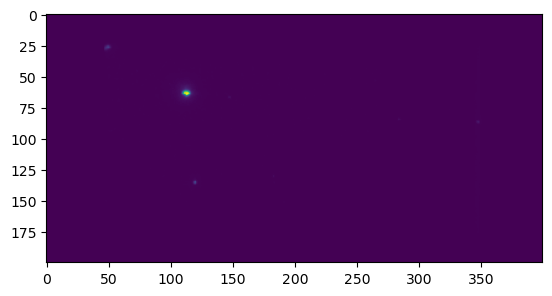

In [71]:
# fig, ax = plt.subplots()
# ax.imshow(image_array_F)

In [85]:
# img_centers_red_tfd = generate_img(FQ_centers_matched[:,1],FQ_centers_matched[:,0], 0, 0, y_border, x_border, 1, True, 1)
        
# fig, ax = plt.subplots()
# ax.imshow(img_centers_red_tfd)

# for blob in FQ_centers_matched:
#     c = plt.Circle(blob, 3, color="red", linewidth=1, fill=False)
#     ax.add_patch(c)
# ax.set_axis_off()
# # plt.savefig(os.path.join(current_direct, 'QC_composites' , pos + "_QC.png"))
# plt.show()
# # a[:,256:] = 50
# # a[:,0:10] = 200
# # print(a[1,1])
# # a = exposure.rescale_intensity(a)
# # a = img_as_ubyte(a)
# # print(a[1,1])
# # print(a[1,11])
# # percentiles = np.percentile(a, (0.5, 99.5))
# # a1 = exposure.rescale_intensity(a, in_range=tuple(percentiles))
# # b = np.zeros((256,512,3), dtype=np.uint8)
# # b[:,:,0] = a1
# # b[:,:,1] = a1
# # # print(a1[0,400])
# # fig, ax = plt.subplots()
# # # QC_composite = Image.fromarray(b)
# # QC_composite = Image.fromarray(b, mode = 'RGB')
# # ax.imshow(QC_composite)
# # plt.show()
# # # print(np.asarray(QC_composite))


In [86]:
# print(FQ_centers_matched)

In [299]:
idx = [i for i,x in enumerate(x_coord) if x_coord[i] >= X_c and (x_coord[i] <= X_c+x_border) and (y_coord[i] >= Y_c) and (y_coord[i] <= Y_c+y_border)]
x_FQ = [x_coord[i] for i in idx]
y_FQ = [y_coord[i] for i in idx]
seq_t = [sequence[i] for i in idx]
print(len(seq_t))


# Selecting the library sequences for further analysis
idx = [i for i,x in enumerate(seq_t) if library_seq in x]
x_FQ = [x_FQ[i] for i in idx]
y_FQ = [y_FQ[i] for i in idx]
seq_t = [seq_t[i] for i in idx]
print(len(seq_t))

839
212


In [23]:
cv2.destroyAllWindows()


In [289]:
print(uknmatchstars_coord
     )
print(refmatchstars_coord)
print(apriori_tr_inv(uknmatchstars_coord))
rough_tr1 = transform.estimate_transform("similarity", src=movie_centers1, dst=seq_centers1)

print(rough_tr1.params)

[[ 78.88382524  30.3282569 ]
 [ 96.12348196  26.01102873]
 [148.97664712 146.62180215]
 [164.58163242 122.65675114]
 [138.84426975 142.43887848]
 [339.82425819 146.46740126]
 [270.01315275  99.05299786]
 [ 73.09175283 139.06518161]
 [266.78297471 134.92005379]]
[[ 72.89899142  65.00466657]
 [ 87.05277384  61.08197713]
 [142.95605859 180.09675988]
 [157.92808049 157.11873693]
 [131.95997482 177.0008095 ]
 [333.88392776 179.94918804]
 [262.01930215 130.96473645]
 [ 66.94482759 174.02681992]
 [258.94775661 166.13398894]]
[[ 53.18321097  12.25245476]
 [ 81.97068069   4.93855465]
 [170.99279527 206.20967359]
 [196.93587118 166.06825331]
 [154.03489625 199.27683764]
 [489.95034085 204.85972367]
 [373.00566252 126.01673205]
 [ 44.12519848 194.01466214]
 [367.81236128 185.97884943]]
[[ 5.96868704e-01  4.42700340e-03  3.95201532e+01]
 [-4.42700340e-03  5.96868704e-01  5.82478600e+01]
 [ 0.00000000e+00  0.00000000e+00  1.00000000e+00]]


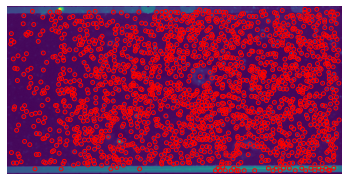

In [291]:
fig, ax = plt.subplots()
ax.imshow(combined)
blobs_log = blob_log(combined, max_sigma=10, num_sigma=10, threshold=1000) # Was 1000 for 19/07/2022
#             Was 300 for 06/09/2022
CM = []
r = 3
[h,w] = red.shape
n_frames = img_smFRET.shape[0]

for i, blob in enumerate(blobs_log):
    x, y, d = blob
    if x>r and x<(h-r) and y>r and y<(w-r):
        temp = ndimage.measurements.center_of_mass(combined[int(x-r):int(x+r+1),int(y-r):int(y+r+1)])
        CM.append(np.flip(np.add(temp, [x-r,y-r])))

        c = plt.Circle(CM[-1], 3, color="red", linewidth=1, fill=False)
        ax.add_patch(c)
ax.set_axis_off()
plt.savefig(os.path.join(pos_direct, pos + "_smFRET_peaks.tif"))
plt.show()

In [300]:
smFRET_centers = np.array(CM)
FQ_centers = np.concatenate((x_FQ, y_FQ)).reshape((-1, 2), order='F')
res, idx = count_nearest_pts(rough_tr1(smFRET_centers), FQ_centers, 8)
movie_centers1 = smFRET_centers[idx[np.where(res != inf)]]
seq_centers1 = FQ_centers[np.where(res != inf)]
print(FQ_centers)


[[1351.7 2237.9]
 [1351.5 2208.6]
 [1347.8 2130. ]
 [1346.9 2176.5]
 [1346.8 2294.6]
 [1343.5 2193.5]
 [1342.3 2223.4]
 [1336.3 2184.5]
 [1334.5 2280.7]
 [1327.4 2145.5]
 [1324.3 2275.3]
 [1324.1 2281.9]
 [1323.4 2222.9]
 [1323.  2129.6]
 [1320.2 2112. ]
 [1316.  2214. ]
 [1315.6 2223.9]
 [1310.8 2158. ]
 [1308.9 2110.7]
 [1304.3 2255.4]
 [1302.8 2139.2]
 [1302.2 2099.3]
 [1293.8 2253.3]
 [1293.8 2112. ]
 [1293.5 2232.8]
 [1290.3 2238.4]
 [1289.7 2269.8]
 [1287.3 2235.8]
 [1287.  2217.1]
 [1287.  2186.1]
 [1285.8 2155.6]
 [1284.8 2116.5]
 [1283.4 2123. ]
 [1281.3 2176.3]
 [1280.9 2256.9]
 [1278.3 2247.8]
 [1276.6 2264.2]
 [1274.4 2122.9]
 [1273.6 2157.7]
 [1271.3 2212.2]
 [1269.8 2188.1]
 [1268.1 2225. ]
 [1267.1 2159.6]
 [1266.7 2208.5]
 [1265.1 2204. ]
 [1264.3 2104.4]
 [1263.5 2100.6]
 [1262.  2233.4]
 [1259.7 2295. ]
 [1259.5 2164.2]
 [1257.4 2211.5]
 [1256.5 2111.4]
 [1253.5 2200.3]
 [1253.2 2295.7]
 [1251.8 2223.5]
 [1248.4 2177.7]
 [1247.8 2219. ]
 [1247.1 2294.2]
 [1246.7 2249.

In [216]:
# DO NOT RUN BY DEFAULT! Removing the last position.
matched_sequences = matched_sequences[:-1]
matched_centers_red = matched_centers_red[:-1]
matched_centers_green = matched_centers_green[:-1]
good_pos = good_pos[:-1]

In [194]:
src = rough_tf1(smFRET_centers)
dst = FQ_centers
tree = spatial.KDTree(src)
print(len(src), len(dst))
res, idx = tree.query(dst, k=1, distance_upper_bound=8)
for i in range(0, len(idx)):
#     i = 0
    idx_t = np.argwhere(idx == idx[i])
    # print(len(idx_t))
    # print(idx)
    if len(idx_t) > 1:
        res_t = [res[j] for j in idx_t]
        if res[i] > min(res_t): res[i] = inf

idx_t1 = np.argwhere(res < inf)
print(len(idx_t1))

1095 1313
136


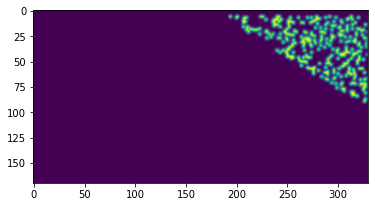

387 2571 [ 6. 11.]
194.4000000000001 341.0 6.099999999999909 97.09999999999991


In [159]:
# fastq_image = generate_img(y_coord,x_coord, 0, 0, max_y, max_x, 1, True, 1)
# image_array_FQ1 = np.asarray(fastq_image)
# idx = [i for i,x in enumerate(x_coord) if x_coord[i] >= X_c and (x_coord[i] <= X_c+330) and (y_coord[i] >= Y_c) and (y_coord[i] <= Y_c+170)]
# x_FQ = [x_coord[i] for i in idx]
# y_FQ = [y_coord[i] for i in idx]
# x_FQ = np.subtract(x_FQ,X_c-shift[1])
# y_FQ = np.subtract(y_FQ,Y_c-shift[0])
# fastq_image1 = generate_img(y_FQ,x_FQ, 0, 0, 170, 330, 1, True, 1)
# # image_array_FQ_t = image_array_FQ1[ Y_c:Y_c+170, X_c:X_c+330]
# # fig, ax = plt.subplots()
# # ax.imshow(image_array_FQ_t)
# # plt.show()
# fig, ax = plt.subplots()
# ax.imshow(fastq_image1)
# plt.show()
# print(X_c,Y_c, shift)
# print(min(x_FQ),max(x_FQ), min(y_FQ), max(y_FQ))

In [212]:
print(len(good_pos), len(matched_sequences), len(matched_centers_red), len(matched_centers_green))

79 79 79 79


In [331]:
# Extracting traces Standard version

for i, pos in enumerate(good_pos):
    # Reading the smFRET movie
#     img_smFRET = io.imread(os.path.join(path_smFRET,pos+'.tiff'))
    img_smFRET = io.imread(os.path.join(path_smFRET,pos,'B_Green','img_000000000.tiff'))
    seq_matched = matched_sequences[i]
    centers_red = matched_centers_red[i]
    centers_green = matched_centers_green[i]
    n_traces = len(centers_red)
    [h,w] = [256,512]
    n_frames = img_smFRET.shape[0]

    weights_red = np.zeros([n_traces,2*r+1,2*r+1])
    weights_green = np.zeros([n_traces,2*r+1,2*r+1])
    traces_red =  np.zeros([n_traces,n_frames])
    traces_green = np.zeros([n_traces,n_frames])
    # Extracting the traces from matched smFRET peaks
    # Extracting the traces from matched smFRET peaks
    # Select matching peaks from peak_locations and their sequences


    for j,coord in enumerate(centers_red):
        x, y = coord
        x0 = int(x-r)
        x1 = int(x+r+1)
        y0 = int(y-r)
        y1 = int(y+r+1)
        dx = x-x0
        dy = y-y0

        it = np.nditer(weights_red[j], flags=['multi_index'], op_flags=['readwrite'])
        for w1 in it:
            yt,xt = it.multi_index
            w1[...] = 2*exp(-0.4*((xt-dx)**2+(yt-dy)**2))
        it.close()

        x, y = centers_green[j]
        x0 = int(x-r)
        x1 = int(x+r+1)
        y0 = int(y-r)
        y1 = int(y+r+1)
        dx = x-x0
        dy = y-y0

        it = np.nditer(weights_green[j], flags=['multi_index'], op_flags=['readwrite'])
        for w1 in it:
            yt,xt = it.multi_index
            w1[...] = 2*exp(-0.4*((xt-dx)**2+(yt-dy)**2))
        it.close()

    for i in range(n_frames):
        if i%100 == 0: print("Working on frame "+str(i))
        red1 = img_smFRET[i,256:,:]
        red1 = red1 - si.restoration.rolling_ball(red1, radius=rb_rad)
        green1 = img_smFRET[i,:256,:]
        green1 = green1 - si.restoration.rolling_ball(green1, radius=rb_rad)

        for j,coord in enumerate(centers_red):
            x, y = coord
            x0 = int(x-r)
            x1 = int(x+r+1)
            y0 = int(y-r)
            y1 = int(y+r+1)
            dx = x-x0
            dy = y-y0
            red2 = red1[y0:y1,x0:x1]
            traces_red[j,i] = np.sum(np.multiply(weights_red[j],red2))

            x, y = centers_green[j]
            x0 = int(x-r)
            x1 = int(x+r+1)
            y0 = int(y-r)
            y1 = int(y+r+1)
            dx = x-x0
            dy = y-y0
            green2 = green1[y0:y1,x0:x1]
            traces_green[j,i] = np.sum(np.multiply(weights_green[j],green2))


    # Save traces and sequences
    frame_rate = 5
    mdict = {
        "time": np.divide(range(n_frames),frame_rate),
        "Cy3": traces_green,
        "Cy5": traces_red,
        "Seq": seq_matched
    }

    savemat(os.path.join(current_direct, pos + "_traces.mat"), mdict)

Working on frame 0
Working on frame 100
Working on frame 200
Working on frame 300
Working on frame 400
Working on frame 0
Working on frame 100
Working on frame 200
Working on frame 300
Working on frame 400
Working on frame 0
Working on frame 100
Working on frame 200
Working on frame 300
Working on frame 400
Working on frame 0
Working on frame 100
Working on frame 200
Working on frame 300
Working on frame 400
Working on frame 0
Working on frame 100
Working on frame 200
Working on frame 300
Working on frame 400
Working on frame 0
Working on frame 100
Working on frame 200
Working on frame 300
Working on frame 400
Working on frame 0
Working on frame 100
Working on frame 200
Working on frame 300
Working on frame 400
Working on frame 0
Working on frame 100
Working on frame 200
Working on frame 300
Working on frame 400
Working on frame 0
Working on frame 100
Working on frame 200
Working on frame 300
Working on frame 400
Working on frame 0
Working on frame 100
Working on frame 200
Working on f

# Main pipeline ends here

In [193]:
# # Skip by default! Figuring out the displacement for tiles.
# file_path = fd.askopenfilename(title = "Choose the position list")

# pos_file = open(file_path)
# data = json.load(pos_file)
# POS = data['POSITIONS']

# labels = [P['LABEL'] for P in POS]
# posX = [P['DEVICES'][0]['X'] for P in POS]
# posY = [P['DEVICES'][0]['Y'] for P in POS]
# # print(min(posX), max(posX), min(posY), max(posY))
# upper_left_um_x = min(posX)
# upper_left_um_y = max(posY)
# file_path_coords = fd.askopenfilename(title = "Choose the coordinate .npy file", initialdir = os.path.dirname(file_path))
# coords_t = np.load(file_path_coords)
# n_t = int(len(coords_t)/2)
# coords_t_seq = coords_t[:n_t,:]
# coords_t_FRET = coords_t[n_t:,:]
# [deltax, deltay] = np.mean(np.subtract(coords_t_seq,coords_t_FRET), axis = 0)
# print(deltax,deltay)
# print(upper_left_um_x, upper_left_um_y)

-2647.7948156235966 826.0597025192474
26529.7 -913.1


In [ ]:

    root = tk.Tk()
    root.attributes("-topmost", True)
    root.withdraw()
    labels_res = []
    posX_res = []
    posY_res = []
    file_path = fd.askopenfilename(title = "Choose the position list", initialdir = "D:/Experiments/MUSCLE DONUTS/20220824_FC_Nano_Cas9_CCR5/parameter")
    pos_file = open(file_path)
    data = json.load(pos_file)
    POS = data['POSITIONS']

    labels = [P['LABEL'] for P in POS]
    posX = [P['DEVICES'][0]['X'] for P in POS]
    posY = [P['DEVICES'][0]['Y'] for P in POS]
    
    for i,x in enumerate(labels):
        x = int(2329 + (posX[i] - 28522.9)/0.34)
        y = int(2042 - (posY[i] + 1313.3)/0.34)
        if (x > 0 ) and (y > 0):
            if (y+y_border<2866) and (x+x_border < 2944) :
                labels_res.append (labels[i])
                posX_res.append (posX[i])
                posY_res.append( posY[i])
    
    
    X_c = [posX[i] for i,x in enumerate(labels) if labels[i]=='Pos279']
    Y_c = [posY[i] for i,x in enumerate(labels) if labels[i]=='Pos279']
    #X_c, Y_c = scaling_seq(X_c[0], Y_c[0])

In [ ]:
app_dir = "C:/Users/panf/Documents/Muscle_intermediates/test_folder_4/"
for pos in labels_res :
    for current_dir,dirs, files in os.walk(app_dir) :
        for el in files: 
            print(el.split('.')[-2])
            print(pos)
            if el.split('.')[-2] == pos:
                img1 = io.imread(current_dir + '/' + el) #reading the stack of images
                
                img1 = img1.astype("ushort") #turn from float format to ushort
                img1 = img1 [256:512, 0:512]
                plt.figure()
                plt.imshow(img1)


In [ ]:
X_c = [posX[i] for i,x in enumerate(labels) if labels[i]=='Pos148']
Y_c = [posY[i] for i,x in enumerate(labels) if labels[i]=='Pos148']

x_c, y_c = scaling_seq (X_c[0], Y_c[0])
print (x_c, y_c)

In [ ]:
import math
seq_coord = np.empty([0,2], dtype=int)
fret_coord = np.empty([0,2], dtype=int)
current_direct = "D:/nanobio/uppsala/muscle/Muscle_Misha/beads/"
for current_dir,dirs, files in os.walk(current_direct) :
        for el in files: 
            coord = np.load(current_dir + '/' + el) 
            length = len(coord)
            fret_coord = np.concatenate ((fret_coord, coord[0:int(length/2)] ), axis = 0 )
            seq_coord = np.concatenate ((seq_coord, coord[int(length/2):length] ), axis = 0 )

seq_coord = seq_coord * 1.7
#print(seq_coord)
#print(fret_coord)
distance1 = []
length = len(seq_coord)
print (length)
res = np.concatenate ((seq_coord, fret_coord), axis = 1)
for i in range(length):
    
    distance1.append(math.sqrt(math.pow((seq_coord[i][0] - fret_coord[i][0]),2) + math.pow((seq_coord[i][1] - fret_coord[i][1]),2)))
    print(math.sqrt(math.pow((seq_coord[i][0] - fret_coord[i][0]),2) + math.pow((seq_coord[i][1] - fret_coord[i][1]),2)))


In [218]:
processed_pos = []

In [250]:
# ALTERNATIVE MAIN CYCLE to reanalyse the data with existing manual bead coordinates
for pos in labels_res :
#     for current_dir,dirs, files in os.walk(beads_dir) :
# #         for el in files:     
#             if el.split('.')[-2] == pos:
    path1 = os.path.join(beads_dir,pos+'.tiff')
    if os.path.exists(path1)&(not os.path.exists(os.path.join(path_smFRET, pos + "_traces.mat")))&(not pos in processed_pos):
#         data['sequence'] = []
        processed_pos.append(pos)
        pos_direct = os.path.join(current_direct, pos)
        os.makedirs(pos_direct, exist_ok=True)
        log_file = open(os.path.join(pos_direct, pos + "_log.txt"), 'w')
        log_file.write('Working on: '+ pos+'\n')
        FRET_coord = []
        seq_coord = []
        point = []
        counter = 0
        rb_rad = 10
        img_beads_F = io.imread(path1) #reading the stack of images
        if len(img_beads_F.shape) == 3:
            img_beads_F = np.mean(img_beads_F, axis = 0) #averaging by the stack
        img_beads_F = img_beads_F.astype("ushort") #turn from float format to ushort
        img_beads_F = img_beads_F [256:512, 0:512]
        img_beads_F = img_beads_F - si.restoration.rolling_ball(img_beads_F, radius=rb_rad)
        image_array_F = transform.warp(img_beads_F, apriori_tr_inv, output_shape = [y_border, x_border])
        image_array_F = img_as_ubyte(image_array_F)
        #img = io.imread(current_dir + '/' + el) #initial reading of original averaging image
        #img = cv2.imread(app.st)
#         plt.figure()
#         plt.imshow(img1)
#         plt.figure()
#         plt.imshow(seq)

        image_array_F = np.asarray(image_array_F) #array from FRET image
#         plt.figure()
#         plt.imshow(image_array_F)
        
        idx = [i for i,x in enumerate(labels_res) if labels_res[i]==pos]
#                 X_c = [posX_res[i] for i,x in enumerate(labels_res) if labels_res[i]==pos]
#                 Y_c = [posY_res[i] for i,x in enumerate(labels_res) if labels_res[i]==pos]
        X_c = [posX_res[i] for i in idx]
        Y_c = [posY_res[i] for i in idx]

        X_c, Y_c = scaling_seq(X_c[0], Y_c[0])
#         print (X_c, Y_c)
        point.append(X_c)
        point.append(Y_c)
        point = np.array(point)
        image_array_seq_t = image_array_seq[ Y_c:Y_c+y_border, X_c:X_c+x_border]
        image_array_max_t = image_array_max[ Y_c:Y_c+y_border, X_c:X_c+x_border]
        image_array_FQ_t = image_array_FQ[ Y_c:Y_c+y_border, X_c:X_c+x_border]
        idx = [i for i,x in enumerate(x_coord) if x_coord[i] >= X_c and (x_coord[i] <= X_c+x_border) and (y_coord[i] >= Y_c) and (y_coord[i] <= Y_c+y_border)]
        x_FQ = [x_coord[i] for i in idx]
        y_FQ = [y_coord[i] for i in idx]
        seq_t = [sequence[i] for i in idx]
        if len(seq_t)<100:
            log_file.write('Not enough (<100) clusters: '+ str(len(seq_t))+ '\n')
            continue



#                 for i in range (len(sequence)):
#                     if (x_coord[i] >= X_c) and (x_coord[i] <= X_c+330): 
#                         if (y_coord[i] >= Y_c) and (y_coord[i] <= Y_c+170):
#                                 data['sequence'].append({
#                                                      'X': x_coord[i],
#                                                      'Y': y_coord[i],
#                                                      'sequence': sequence[i]
#                                                         })

        #print(image_array)
        v_min, v_max = np.percentile(image_array_F, (0, 99.8))
        if v_max == 0: v_max = np.max(image_array_F)
        better_contrast_image_array = exposure.rescale_intensity(image_array_F, in_range=(v_min, v_max))
        better_contrast_img = Image.fromarray(better_contrast_image_array)
        better_contrast_img.save(pos_direct + '/'+pos + '_contr.tif')
        better_contrast_img = cv2.imread(pos_direct + '/'+pos + '_contr.tif')
        #reading by cv2 to make possible circles in color
        #img_jpg = io.imread('C:/Users/panf/Documents/Muscle_intermediates/AVG_G10_1_1_MMStack_Pos0.ome.jpg')
        #img_array = img_as_int(img)
        # displaying the image
        # setting mouse handler for the image
        # and calling the click_event() function
        image_seq = Image.fromarray(image_array_seq_t)
        image_seq.save (pos_direct + '/'+ pos+'_seq.tif')

        image_fastq = Image.fromarray(image_array_FQ_t)
#         plt.figure()
#         plt.imshow(image_fastq)
        image_fastq.save (pos_direct + '/'+ pos+'_fastq.tif')

        v_min, v_max = np.percentile(image_array_seq_t, (0, 99.8))
        if v_max == 0: v_max = np.max(image_array_seq_t)
        better_contrast_image_array_2 = exposure.rescale_intensity(image_array_seq_t, in_range=(v_min, v_max))
        better_contrast_img_2 = Image.fromarray(better_contrast_image_array_2)
        better_contrast_img_2.save(pos_direct + '/'+''+ pos+'_contr_MIN_seq_stack.tif')
        better_contrast_img_2 = cv2.imread(pos_direct + '/'+pos+ '_contr_MIN_seq_stack.tif')     

#         plt.figure()
#         plt.imshow( Image.fromarray(image_array_seq_t))     
        
        # User clicks of beads with "q" for exit when done
        FRET_coord = []
        seq_coord = []
#         cv2.namedWindow(pos) 
#         cv2.namedWindow(pos+'_seq') 
#         cv2.setMouseCallback(pos,  click_event_FRET)
#         cv2.setMouseCallback(pos+'_seq',  click_event_seq)
#         #cv2.setMouseCallback('image1',  click_event)
#         while(1):
#             cv2.imshow(pos,better_contrast_img)
#             cv2.imshow(pos+'_seq',better_contrast_img_2)
#             k = cv2.waitKey(1)&0xFF 
#             #if cv2.waitKey(20) & 0xFF == 27: #press Esc to quit
#             if k == ord('q'): # Press 'q' to finish
#                 if len(seq_coord) == len(FRET_coord):
#                     break
#                 else:
#                     counter = 0
#                     cv2.destroyAllWindows()
#                     FRET_coord = []
#                     seq_coord = []
#                     cv2.namedWindow(pos) 
#                     cv2.namedWindow(pos+'_seq') 
#                     cv2.setMouseCallback(pos,  click_event_FRET)
#                     cv2.setMouseCallback(pos+'_seq',  click_event_seq)
#                     better_contrast_img_2 = cv2.imread(pos_direct + '/'+pos+ '_contr_MIN_seq_stack.tif')
#                     better_contrast_img = cv2.imread(pos_direct + '/'+pos + '_contr.tif')
#             elif k == ord('r'): # Press 'r' to restart
#                 counter = 0
#                 cv2.destroyAllWindows()
#                 FRET_coord = []
#                 seq_coord = []
#                 cv2.namedWindow(pos) 
#                 cv2.namedWindow(pos+'_seq') 
#                 cv2.setMouseCallback(pos,  click_event_FRET)
#                 cv2.setMouseCallback(pos+'_seq',  click_event_seq)
#                 better_contrast_img_2 = cv2.imread(pos_direct + '/'+pos+ '_contr_MIN_seq_stack.tif')
#                 better_contrast_img = cv2.imread(pos_direct + '/'+pos + '_contr.tif')
        
#         cv2.destroyAllWindows()
        
        # If the user selected at least three beads we proceed with analysis
        if os.path.exists(pos_direct + '/' + pos+'_manual_coord.npy'): 
            result = np.load(pos_direct + '/' + pos+'_manual_coord.npy')
#             seq_coord = np.reshape(seq_coord,(int((counter+1)/2), 2))
            
#             FRET_coord = np.reshape(FRET_coord,(int((counter+1)/2), 2))
#             FRET_coord = apriori_tr_inv(FRET_coord)
            split = int(len(result)/2)
            FRET_coord = result[:split,:]
            seq_coord = result[split:,:]
#             np.save(pos_direct + '/' + pos+'_manual_coord', result)
            
            # Calculating the shift between the FASTQ and cluster images using cross-correlation
            shift = phase_cross_correlation(image_array_max_t,image_array_FQ_t)
            shift = shift[0]
            # Translation of the FASTQ sequences in the FOV to match the cluster image
            x_FQ = np.subtract(x_FQ,X_c-shift[1])
            y_FQ = np.subtract(y_FQ,Y_c-shift[0])
            max_image = Image.fromarray(image_array_max_t)
            max_image.save(os.path.join(pos_direct,pos+'_MAX_seq.png'))
            fastq_image1 = generate_img(y_FQ,x_FQ, 0, 0, y_border, x_border, 1, True, 1)
            fastq_image1.save(os.path.join(pos_direct,pos+'_FQ_aligned.png'))
            fig, ax = plt.subplots()
            ax.imshow(fastq_image1)
            plt.show()


            # Selecting the library sequences for further analysis
            idx = [i for i,x in enumerate(seq_t) if library_seq in x]
            x_FQ = [x_FQ[i] for i in idx]
            y_FQ = [y_FQ[i] for i in idx]
            seq_t = [seq_t[i] for i in idx]

            # Calculating the first rough transformation based on manually-selected beads
            rough_tr = transform.estimate_transform("similarity", src=FRET_coord, dst=seq_coord)
            np.save(os.path.join(pos_direct, pos + "_man_bead_tr"), rough_tr)
            # Refining the transformation based on automatically-selected beads
            movie_centers = blob_detection(
                np.asarray(img_beads_F),
                min_sigma=1,
                max_sigma=10,
                threshold=0.01
            )

            seq_centers = blob_detection(
                image_array_seq_t,
                min_sigma=1,
                max_sigma=10,
                threshold=0.0001, # Was 0.00001 for 19/07/2022; 0.0001 for 06/09/2022
             )
            
            res, idx = count_nearest_pts(rough_tr(movie_centers), seq_centers, 8)
            movie_centers1 = movie_centers[idx[np.where(res != inf)]]
            seq_centers1 = seq_centers[np.where(res != inf)]
            print('Automatically matched beads: ',seq_centers1.shape[0])
            if seq_centers1.shape[0] >2:
                log_file.write("Detected " + str(seq_centers1.shape[0]) + " matched beads. Updating the manual transformation\n")                
                rough_tr1 = transform.estimate_transform("similarity", src=movie_centers1, dst=seq_centers1)
            else:
                log_file.write("""Not enough (<3) automatically detected and matched beads to update the initial
                               transformation estimate based on manually selected beads\n""")
                rough_tr1 = rough_tr

            np.save(os.path.join(pos_direct, pos + "_auto_bead_tr"), rough_tr1)
            # Reading the smFRET movie
            img_smFRET = io.imread(os.path.join(path_smFRET,pos+'.tiff'))

            # Averaging the first 10 frames to select peaks
            img_t = np.mean(img_smFRET[0:10,::], axis = 0)
            img_t = img_t.astype("ushort")
            rb_rad = 10
            #print(img1[10:20,10:20])
            #img = np.zeros([20,20])
            #img[10,5] = 1000
            red = img_t[256:,:]
            green = img_t[:256,:]
            red = red - si.restoration.rolling_ball(red, radius=rb_rad)
            green = green - si.restoration.rolling_ball(green, radius=rb_rad)
            green = transform.warp(green,tr_R2G, preserve_range = True)
            combined = red + green # Consider adding the red excitation channel, though there are some difficulties, e.g. beads and int scaling
            fig, ax = plt.subplots()
            ax.imshow(combined)
            blobs_log = blob_log(combined, max_sigma=10, num_sigma=10, threshold=300) # Was 1000 for 19/07/2022; 300 for 06/09/2022
            CM = []
            r = 3
            [h,w] = red.shape
            n_frames = img_smFRET.shape[0]

            for i, blob in enumerate(blobs_log):
                x, y, d = blob
                if x>r and x<(h-r) and y>r and y<(w-r):
                    temp = ndimage.measurements.center_of_mass(combined[int(x-r):int(x+r+1),int(y-r):int(y+r+1)])
                    CM.append(np.flip(np.add(temp, [x-r,y-r])))

                    c = plt.Circle(CM[-1], 3, color="red", linewidth=1, fill=False)
                    ax.add_patch(c)
            ax.set_axis_off()
            plt.savefig(os.path.join(pos_direct, pos + "_smFRET_peaks.tif"))
            plt.show()
            
            
            smFRET_centers = np.array(CM)
            FQ_centers = np.concatenate((x_FQ, y_FQ)).reshape((-1, 2), order='F')
            res, idx = count_nearest_pts(rough_tr1(smFRET_centers), FQ_centers, 8)
            movie_centers1 = smFRET_centers[idx[np.where(res != inf)]]
            seq_centers1 = FQ_centers[np.where(res != inf)]

            # Calculating the polynomial tranformation between FRET peaks and clusters
            
#             if seq_centers1.shape[0]>=9:
#                 order = 2
#             if seq_centers1.shape[0]>=4:
#                 order = 1
#             else: continue
            if seq_centers1.shape[0]<4: 
                log_file.write('Not enough smFRET peaks (<4)')
                continue
            
            tr = transform.estimate_transform("similarity", src=movie_centers1, dst=seq_centers1)
            tr_inv = transform.estimate_transform("similarity", src=seq_centers1, dst=movie_centers1)
            np.save(os.path.join(pos_direct, pos + "_final_tr"), tr)
            np.save(os.path.join(pos_direct, pos + "_final_tr_inv"), tr_inv)
            log_file.write('Matched clusters before polywarp: ' + str(seq_centers1.shape[0])+'\n')
            print('Matched clusters before polywarp: ',seq_centers1.shape[0])
            
#             kx,ky = Polywarp.polywarp(seq_centers1[:,0],seq_centers1[:,1],movie_centers1[:,0],movie_centers1[:,1],degree=order)
# #             print(kx)
# #             print(ky)
#             tr = transform.PolynomialTransform()
#             #tr.estimate(src,dst,order = 2)

#             order1 = 2*order
#             pidx = 0
#             par = np.zeros([2,int((order1+1)*(order1+2)/2)])
#             for j in range(order1 + 1):
#                 for i in range(j + 1):
#                     if (j-i)<=order and i<=order:
#                         par[0, pidx] = kx[j - i,i]
#                         par[1, pidx] = ky[j - i,i]
#                     else:
#                         par[0, pidx] = 0
#                         par[1, pidx] = 0
#                     pidx += 1
#             tr.params = par        

#             kx,ky = Polywarp.polywarp(movie_centers1[:,0],movie_centers1[:,1],seq_centers1[:,0],seq_centers1[:,1],degree=order)
#             tr_inv = transform.PolynomialTransform()
#             #tr.estimate(src,dst,order = 2)

#             order1 = 2*order
#             pidx = 0
#             par = np.zeros([2,int((order1+1)*(order1+2)/2)])
#             for j in range(order1 + 1):
#                 for i in range(j + 1):
#                     if (j-i)<=order and i<=order:
#                         par[0, pidx] = kx[j - i,i]
#                         par[1, pidx] = ky[j - i,i]
#                     else:
#                         par[0, pidx] = 0
#                         par[1, pidx] = 0
#                     pidx += 1
#             tr_inv.params = par

            res, idx = count_nearest_pts(tr(smFRET_centers), FQ_centers, 8) # Was 4 for 19/07/2022
            centers_matched = smFRET_centers[idx[np.where(res != inf)]]
            idx_t = np.where(res != inf)
            seq_matched = [seq_t[i] for i in idx_t[0]]
            FQ_centers_matched = FQ_centers[idx_t]
            
            
            centers_red = centers_matched
            centers_green = tr_R2G(centers_matched)
            r = 3
            # Weed out positions that are too close to the edge
            idx_t = np.where((centers_red[:,0]>r) & (centers_red[:,0]<(w-r)) & (centers_red[:,1]>r) & (centers_red[:,1]<(h-r))  & 
                             (centers_green[:,0]>r) & (centers_green[:,0]<(w-r)) & (centers_green[:,1]>r) & (centers_green[:,1]<(h-r)))
            centers_red = centers_red [idx_t]
            centers_green = centers_green [idx_t]
            seq_matched = [seq_matched[i] for i in idx_t[0]]
            
            matched_sequences.append(seq_matched)
            matched_centers_red.append(centers_red)
            matched_centers_green.append(centers_green)
            good_pos.append(pos)
            log_file.write('Matched clusters after polywarp: ' + str(len(seq_matched))+'\n')
            log_file.write('Out of ' + str(len(smFRET_centers)) + ' smFRET peaks and ' + str(len(FQ_centers)) + ' clusters'+'\n')
            log_file.write('Percentage of matched smFRET peaks: ' + str(int(100*len(seq_matched)/len(smFRET_centers)))+'\n')
            log_file.write('Percentage of matched clusters: ' + str(int(100*len(seq_matched)/len(FQ_centers)))+'\n')
            print('Matched clusters after polywarp: ',len(seq_matched))
            print('Out of ',len(smFRET_centers), ' smFRET peaks and ', len(FQ_centers), ' clusters')
            print('Percentage of matched smFRET peaks: ',int(100*len(seq_matched)/len(smFRET_centers)))
            print('Percentage of matched clusters: ',int(100*len(seq_matched)/len(FQ_centers)))
            # Saving transformed bead and molecule images for QC
            img_beads_tfd = Image.fromarray(transform.warp(img_beads_F, tr_inv, output_shape = [y_border, x_border]))
            img_beads_tfd.save(os.path.join(pos_direct, pos + "_beads_transformed.tif"))
            img_smFRET_tfd = Image.fromarray(transform.warp(combined, tr_inv, output_shape = [y_border, x_border]))
            img_smFRET_tfd.save(os.path.join(pos_direct, pos + "_smFRET_transformed.tif"))
            centers_red_tfd = tr(centers_red)
            img_centers_red_tfd = generate_img(centers_red_tfd[:,1],centers_red_tfd[:,0], 0, 0, y_border, x_border, 1, True, 1)
            img_centers_red_tfd.save(os.path.join(pos_direct, pos + "_smFRET_peaks_matched_transformed.tif"))
            
            centers_red_tfd = tr(smFRET_centers)
            img_centers_red_tfd = generate_img(centers_red_tfd[:,1],centers_red_tfd[:,0], 0, 0, y_border, x_border, 1, True, 1)
            img_centers_red_tfd.save(os.path.join(pos_direct, pos + "_smFRET_peaks_all_transformed.tif"))
            
            img_centers_red_tfd = generate_img(FQ_centers_matched[:,1],FQ_centers_matched[:,0], 0, 0, y_border, x_border, 1, True, 1)
            img_centers_red_tfd.save(os.path.join(pos_direct, pos + "_FQ_lib_matched.tif"))
                    
            img_centers_red_tfd = generate_img(FQ_centers[:,1],FQ_centers[:,0], 0, 0, y_border, x_border, 1, True, 1)
            img_centers_red_tfd.save(os.path.join(pos_direct, pos + "_FQ_lib_all.tif"))
        else:   log_file.write('Not enough manually matched beads\n')

# Save good pos data to be able to extract traces later
frame_rate = 5
mdict1 = {
    "good_pos": good_pos,
    "matched_sequences": matched_sequences,
    "matched_centers_red": matched_centers_red,
    "matched_centers_green": matched_centers_green
}

savemat(os.path.join(current_direct, "good_pos.mat"), mdict1)


In [205]:
print(Y_c,X_c
     )

1896 -73


In [78]:
# from skimage.measure import ransac
# from sklearn.linear_model import RANSACRegressor

# # print(movie_centers)
# # print(seq_centers)

# """ 
#     Wrapped polynomial transformation for Ransac using.
# """
# class QuadPolyTrans(transform.PolynomialTransform):
#     def estimate(*data):
#         return transform.PolynomialTransform.estimate(*data, order=2)


# class CubicPolyTrans(transform.PolynomialTransform):
#     def estimate(*data):
#         return transform.PolynomialTransform.estimate(*data, order=3)
# model, inliers = ransac(
#     (FQ_centers_all1, MAX_centers1),
#     transform.SimilarityTransform,
#     20,
#     2,
#     initial_inliers=np.ones(len(MAX_centers1), dtype=bool),
#     stop_probability=0.999
# )
# print(model.params)
# print(inliers)
# FQ_centers_all2 = FQ_centers_all1[np.where(inliers == True)]
# MAX_centers2 = MAX_centers1[np.where(inliers == True)]



# print('Residuals after poly (order = '+str(order)+') transformation: ',mean_squared_error(model(FQ_centers_all1), MAX_centers1))
# print('Residuals before transformation: ',mean_squared_error(FQ_centers_all1, MAX_centers1))


# order = 3
# kx,ky = Polywarp.polywarp(MAX_centers2[:,0],MAX_centers2[:,1],FQ_centers_all2[:,0],FQ_centers_all2[:,1],degree=order)
# print(kx)
# print(ky)
# trFQtoMAX = transform.PolynomialTransform()
# #tr.estimate(src,dst,order = 2)
# order1 = 2*order
# pidx = 0
# par = np.zeros([2,int((order1+1)*(order1+2)/2)])
# for j in range(order1 + 1):
#     for i in range(j + 1):
#         if (j-i)<=order and i<=order:
#             par[0, pidx] = kx[j - i,i]
#             par[1, pidx] = ky[j - i,i]
#         else:
#             par[0, pidx] = 0
#             par[1, pidx] = 0
#         pidx += 1
# trFQtoMAX.params = par  
# print('Residuals after poly (order = '+str(order)+') transformation: ',mean_squared_error(trFQtoMAX(FQ_centers_all1), MAX_centers1))
# print('Residuals before transformation: ',mean_squared_error(FQ_centers_all1, MAX_centers1))

[[ 1.00026417  0.00628967 -0.98098477]
 [-0.00628967  1.00026417  0.96694104]
 [ 0.          0.          1.        ]]
[False  True  True  True  True  True  True  True  True  True  True  True
 False  True  True  True  True  True  True  True  True  True False  True
  True  True False  True  True  True  True  True  True  True  True  True
  True  True  True  True  True  True  True  True  True  True  True  True
  True  True  True  True  True  True  True  True  True  True  True  True
  True  True  True  True  True  True  True  True  True  True  True  True
  True  True  True  True  True  True  True  True  True  True  True  True
  True  True  True  True  True  True  True  True  True  True  True  True
  True  True  True  True  True False  True  True  True  True  True  True
  True  True  True  True  True  True  True  True  True  True False  True
 False  True  True  True  True  True  True  True  True  True  True  True
  True  True  True  True  True  True  True  True  True  True  True  True
  True

C:\Users\Anton\AppData\Local\Temp\ipykernel_18028\1823133743.py:208: DeprecationWarning: Please use `center_of_mass` from the `scipy.ndimage` namespace, the `scipy.ndimage.measurements` namespace is deprecated.
  ndimage.measurements.center_of_mass(


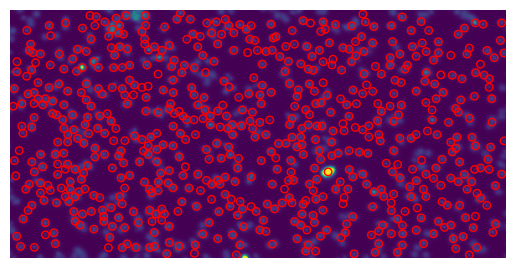

[[255.2 128.6]
 [ 58.4  46.7]
 [375.5   9. ]
 ...
 [347.7  53.3]
 [268.3  92.5]
 [ 43.7 127.1]]
[[256.03398998 130.04835163]
 [ 57.88586957  45.92482576]
 [374.79698552   9.85693836]
 ...
 [346.91935484  51.85190616]
 [267.96051227  91.16755603]
 [ 44.02932002 127.9095446 ]]
Residuals after poly (order = 2) transformation:  0.5216303260676192
Residuals before transformation:  0.8044996523899008


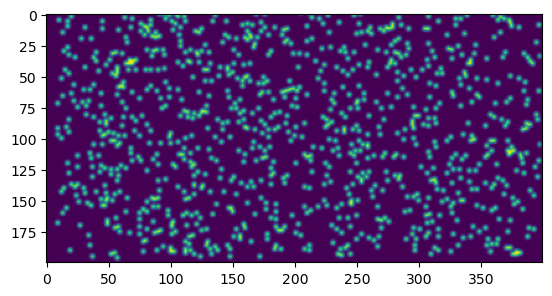

C:\Users\Anton\AppData\Local\Temp\ipykernel_18028\1823133743.py:208: DeprecationWarning: Please use `center_of_mass` from the `scipy.ndimage` namespace, the `scipy.ndimage.measurements` namespace is deprecated.
  ndimage.measurements.center_of_mass(


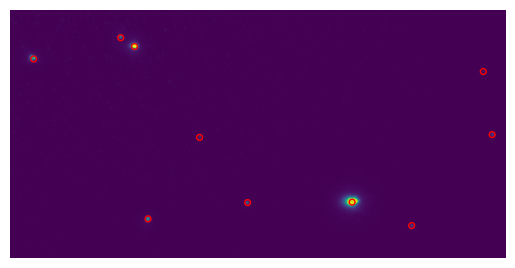

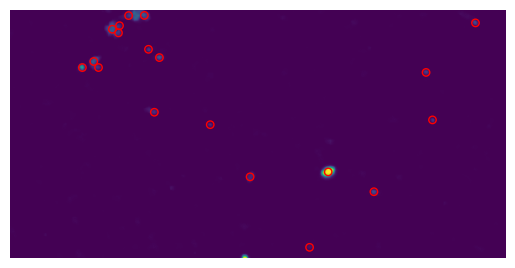

1.0632304186366968 0.0054964089995560485
0.9883920898330891 0.005794007484621328
1.0632304186366968 0.008215765323358187
0.9883920898330891 0.008447779435565118
Pos315
 [[119.99846326  37.87692093]
 [256.11206071 130.07923121]
 [ 57.87235071  45.9188816 ]
 [111.17187068  31.19894999]
 [193.14019608 134.05921569]
 [292.96314026 146.05919898]
 [340.21480197  88.1274935 ]
 [160.97442186  91.99264191]
 [335.02822308  49.83924136]
 [123.60895999  45.4178404 ]
 [257.69548171 141.99894259]
 [ 61.3187214   52.87701004]
 [115.14565161  39.94238349]
 [193.14589707 142.01176693]
 [294.40579025 156.58509234]
 [344.31716722 100.56817567]
 [163.61866165 101.68023335]
 [338.97380244  61.59677766]]
Automatically matched beads:  9


C:\Users\Anton\AppData\Local\Temp\ipykernel_18028\4185456068.py:226: DeprecationWarning: Please use `center_of_mass` from the `scipy.ndimage` namespace, the `scipy.ndimage.measurements` namespace is deprecated.
  temp = ndimage.measurements.center_of_mass(combined[int(x-r):int(x+r+1),int(y-r):int(y+r+1)])


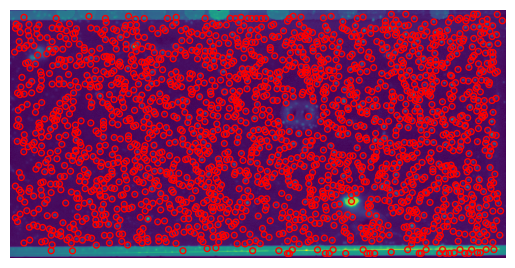

[[ 4.37494992e+01  6.94218422e-03  3.63221573e-06]
 [ 5.88858357e-01  4.67784133e-05 -1.22279908e-07]
 [ 1.46501962e-05 -1.00588041e-07  2.42052471e-10]]
[[ 1.48770815e+01  6.07221675e-01 -1.56541108e-05]
 [-5.85112397e-04 -8.33936552e-05  9.14299703e-08]
 [-8.94672047e-06  1.12557148e-07 -8.47377929e-11]]
Matched clusters before transform update:  126
Matched clusters after transform update:  84
Out of  1926  smFRET peaks and  258  clusters
Percentage of matched smFRET peaks:  4
Percentage of matched clusters:  32


TypeError: 'Image' object is not subscriptable

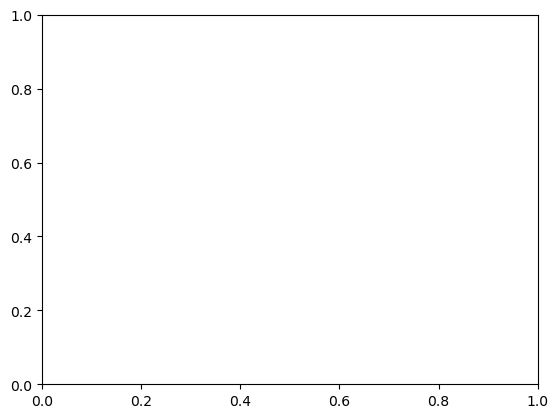

In [84]:
# MAIN CYCLE test
processed_pos = []

os.makedirs(os.path.join(current_direct, 'QC_composites'), exist_ok=True)
os.makedirs(os.path.join(current_direct, 'QC_composites_raw'), exist_ok=True)
# for pos in labels_res :
#     for current_dir,dirs, files in os.walk(beads_dir) :
# #         for el in files:     
#             if el.split('.')[-2] == pos:
#     path1 = os.path.join(beads_dir,pos+'.tiff')
path1 = os.path.join(beads_dir,pos,'A_Red_2','img_000000000.tiff')
if os.path.exists(path1)&(not os.path.exists(os.path.join(path_smFRET, pos + "_traces.mat")))&(not pos in processed_pos):
#         data['sequence'] = []

    processed_pos.append(pos)
    pos_direct = os.path.join(current_direct, pos)
    os.makedirs(pos_direct, exist_ok=True)
    log_file = open(os.path.join(pos_direct, pos + "_log.txt"), 'w')
    log_file.write('Working on: '+ pos+'\n')
    FRET_coord = []
    seq_coord = []
    point = []
    counter = 0
    rb_rad = 10
    img_beads_F = io.imread(path1) #reading the stack of images
    if len(img_beads_F.shape) == 3:
        img_beads_F = np.mean(img_beads_F, axis = 0) #averaging by the stack
    img_beads_F = img_beads_F.astype("ushort") #turn from float format to ushort
    img_beads_F = img_beads_F [256:512, 0:512]
    img_beads_F = img_beads_F - rolling_ball(img_beads_F, radius=rb_rad)
    image_array_F = transform.warp(img_beads_F, apriori_tr_inv, output_shape = [y_border, x_border])
    image_array_F = img_as_ubyte(image_array_F)
    #img = io.imread(current_dir + '/' + el) #initial reading of original averaging image
    #img = cv2.imread(app.st)
#         plt.figure()
#         plt.imshow(img1)
#         plt.figure()
#         plt.imshow(seq)

    image_array_F = np.asarray(image_array_F) #array from FRET image
#         plt.figure()
#         plt.imshow(image_array_F)

    idx = [i for i,x in enumerate(labels_res) if labels_res[i]==pos]
#                 X_c = [posX_res[i] for i,x in enumerate(labels_res) if labels_res[i]==pos]
#                 Y_c = [posY_res[i] for i,x in enumerate(labels_res) if labels_res[i]==pos]
    X_c = [posX_res[i] for i in idx]
    Y_c = [posY_res[i] for i in idx]

    X_c, Y_c = scaling_seq(X_c[0], Y_c[0])
#         print (X_c, Y_c)
    point.append(X_c)
    point.append(Y_c)
    point = np.array(point)
    image_array_seq_t = image_array_seq[ Y_c:Y_c+y_border, X_c:X_c+x_border]
    image_array_max_t = image_array_max[ Y_c:Y_c+y_border, X_c:X_c+x_border]
    image_array_FQ_t = image_array_FQ[ Y_c:Y_c+y_border, X_c:X_c+x_border]
    idx = [i for i,x in enumerate(x_coord) if x_coord[i] >= X_c and (x_coord[i] <= X_c+x_border) and (y_coord[i] >= Y_c) and (y_coord[i] <= Y_c+y_border)]
    x_FQ = [x_coord[i] for i in idx]
    y_FQ = [y_coord[i] for i in idx]
    seq_t = [sequence[i] for i in idx]
    if len(seq_t)<100:
        log_file.write('Not enough (<100) clusters: '+ str(len(seq_t))+ '\n')
#         continue

    #print(image_array)

    #reading by cv2 to make possible circles in color
    #img_jpg = io.imread('C:/Users/panf/Documents/Muscle_intermediates/AVG_G10_1_1_MMStack_Pos0.ome.jpg')
    #img_array = img_as_int(img)
    # displaying the image
    # setting mouse handler for the image
    # and calling the click_event() function
    image_seq = Image.fromarray(image_array_seq_t)
    image_seq.save (pos_direct + '/'+ pos+'_seq.tif')

    image_fastq = Image.fromarray(image_array_FQ_t)
    image_fastq.save (pos_direct + '/'+ pos+'_fastq.tif')

    v_min, v_max = np.percentile(image_array_seq_t, (0, 99.8))
    if v_max == 0: v_max = np.max(image_array_seq_t)  

    # Calculating the shift between the FASTQ and cluster images using cross-correlation
    shift = phase_cross_correlation(image_array_max_t,image_array_FQ_t)
    shift = shift[0]
    # Translation of the FASTQ sequences in the FOV to match the cluster image
    x_FQ = np.subtract(x_FQ,X_c-shift[1])
    y_FQ = np.subtract(y_FQ,Y_c-shift[0])
    max_image = Image.fromarray(image_array_max_t)
    max_image.save(os.path.join(pos_direct,pos+'_MAX_seq.png'))

#     fastq_image_ = generate_img(y_coord,x_coord, 0, 0, max_y, max_x, 1, True, 1)
    MAX_centers = blob_detection(
        image_array_max_t,
        min_sigma=1,
        max_sigma=10,
        threshold=0.0001
    )
    FQ_centers_all = np.concatenate((x_FQ, y_FQ)).reshape((-1, 2), order='F')
    res, idx = count_nearest_pts(FQ_centers_all, MAX_centers, 2)
    FQ_centers_all1 = FQ_centers_all[idx[np.where(res != inf)]]
    MAX_centers1 = MAX_centers[np.where(res != inf)]
    print(FQ_centers_all1)
    print(MAX_centers1)
    
    trFQtoMAX = transform.estimate_transform("similarity", src=FQ_centers_all1, dst=MAX_centers1)
#     order = 4
#     kx,ky = Polywarp.polywarp(MAX_centers1[:,0],MAX_centers1[:,1],FQ_centers_all1[:,0],FQ_centers_all1[:,1],degree=order)
#     print(kx)
#     print(ky)
#     trFQtoMAX = transform.PolynomialTransform()
#     #tr.estimate(src,dst,order = 2)
#     order1 = 2*order
#     pidx = 0
#     par = np.zeros([2,int((order1+1)*(order1+2)/2)])
#     for j in range(order1 + 1):
#         for i in range(j + 1):
#             if (j-i)<=order and i<=order:
#                 par[0, pidx] = kx[j - i,i]
#                 par[1, pidx] = ky[j - i,i]
#             else:
#                 par[0, pidx] = 0
#                 par[1, pidx] = 0
#             pidx += 1
#     trFQtoMAX.params = par  
    print('Residuals after poly (order = '+str(order)+') transformation: ',mean_squared_error(trFQtoMAX(FQ_centers_all1), MAX_centers1))
    print('Residuals before transformation: ',mean_squared_error(FQ_centers_all1, MAX_centers1))
    
    
    temp = trFQtoMAX(FQ_centers_all)
    x_FQ = temp[:,0];
    y_FQ = temp[:,1];
    
    
    fastq_image1 = generate_img(y_FQ,x_FQ, 0, 0, y_border, x_border, 1, True, 1)
    fastq_image1.save(os.path.join(pos_direct,pos+'_FQ_aligned.png'))
    max_image = generate_img(MAX_centers[:,1],MAX_centers[:,0], 0, 0, y_border, x_border, 1, True, 1)
    max_image.save(os.path.join(pos_direct,pos+'_MAX_seq_CoM.png'))
    fig, ax = plt.subplots()
    ax.imshow(fastq_image1)
    plt.show()

    # Selecting the library sequences for further analysis
    idx = [i for i,x in enumerate(seq_t) if library_seq in x]
    x_FQ = [x_FQ[i] for i in idx]
    y_FQ = [y_FQ[i] for i in idx]
    seq_t = [seq_t[i] for i in idx]

    # Calculating the transformation based on automatically-selected beads
    movie_centers = blob_detection(
        np.asarray(img_beads_F),
        min_sigma=1,
        max_sigma=10,
        threshold=0.01
    )

    seq_centers = blob_detection(
        image_array_seq_t,
        min_sigma=1,
        max_sigma=10,
        threshold=0.001, # Was 0.00001 for 19/07/2022
     )

    a = run(seq_centers, apriori_tr(movie_centers))

    uknmatchstars_coord = []
    refmatchstars_coord = []
    if len(a[0].refmatchstars) >= 3:
        for i in range (len(a[0].refmatchstars)):
            uknmatchstars_coord.append(a[0].uknmatchstars[i].x)
            uknmatchstars_coord.append(a[0].uknmatchstars[i].y)
            refmatchstars_coord.append(a[0].refmatchstars[i].x)
            refmatchstars_coord.append(a[0].refmatchstars[i].y)

        refmatchstars_coord = np.array(refmatchstars_coord)
        uknmatchstars_coord = np.array(uknmatchstars_coord)

        refmatchstars_coord = np.reshape ( refmatchstars_coord, ( int(len(a[0].refmatchstars)), 2 ) )
        uknmatchstars_coord = np.reshape ( uknmatchstars_coord, ( int(len(a[0].uknmatchstars)), 2 ) )
        result_coord = np.concatenate ((refmatchstars_coord,uknmatchstars_coord ), axis = 0)
        print (pos+"\n", result_coord )
        np.save (os.path.join(pos_direct, pos + "_matching_beads"), result_coord)
    else:
        log_file.write("""Not enough (<3) automatically detected and matched beads to update the initial
                       transformation estimate based on manually selected beads\n""")
#         continue
#         res, idx = count_nearest_pts(rough_tr(movie_centers), seq_centers, 8)
#         movie_centers1 = movie_centers[idx[np.where(res != inf)]]
#         seq_centers1 = seq_centers[np.where(res != inf)]
    movie_centers1 = apriori_tr_inv(uknmatchstars_coord)
    seq_centers1 = refmatchstars_coord
    print('Automatically matched beads: ',seq_centers1.shape[0])
    rough_tr1 = transform.estimate_transform("similarity", src=movie_centers1, dst=seq_centers1)
    np.save(os.path.join(pos_direct, pos + "_auto_bead_tr"), rough_tr1)
    # Reading the smFRET movie
#             path_smFRET_file = os.path.join(path_smFRET,pos+'.tiff')
    path_smFRET_file = os.path.join(path_smFRET,pos,'B_Green','img_000000000.tiff')
#     if not os.path.exists(path_smFRET_file):
#         continue

    img_smFRET = io.imread(path_smFRET_file)

    # Averaging the first 10 frames to select peaks
    img_t = np.mean(img_smFRET[0:10,::], axis = 0)
    img_t = img_t.astype("ushort")
    rb_rad = 10

    red = img_t[256:,:]
    green = img_t[:256,:]
    red = red - rolling_ball(red, radius=rb_rad)
    green = green - rolling_ball(green, radius=rb_rad)
    green = transform.warp(green,tr_R2G, preserve_range = True)
    combined = red + green # Consider adding the red excitation channel, though there are some difficulties, e.g. beads and int scaling
    fig, ax = plt.subplots()
    ax.imshow(combined)
    blobs_log = blob_log(combined, max_sigma=10, num_sigma=10, threshold=1000) # Was 1000 for 19/07/2022
#             Was 300 for 06/09/2022
    CM = []
    r = 3
    [h,w] = red.shape
    n_frames = img_smFRET.shape[0]

    for i, blob in enumerate(blobs_log):
        x, y, d = blob
        if x>r and x<(h-r) and y>r and y<(w-r):
            temp = ndimage.measurements.center_of_mass(combined[int(x-r):int(x+r+1),int(y-r):int(y+r+1)])
            CM.append(np.flip(np.add(temp, [x-r,y-r])))

            c = plt.Circle(CM[-1], 3, color="red", linewidth=1, fill=False)
            ax.add_patch(c)
    ax.set_axis_off()
    plt.savefig(os.path.join(pos_direct, pos + "_smFRET_peaks.tif"))
    plt.show()


    smFRET_centers = np.array(CM)
    FQ_centers = np.concatenate((x_FQ, y_FQ)).reshape((-1, 2), order='F')
    res, idx = count_nearest_pts(rough_tr1(smFRET_centers), FQ_centers, 2)
    movie_centers1 = smFRET_centers[idx[np.where(res != inf)]]
    seq_centers1 = FQ_centers[np.where(res != inf)]

    if seq_centers1.shape[0]<4:
        print('Not enough smFRET peaks (<4)')
        log_file.write('Not enough smFRET peaks (<4)')
#         continue
    
    order = 2
    kx,ky = Polywarp.polywarp(seq_centers1[:,0],seq_centers1[:,1],movie_centers1[:,0],movie_centers1[:,1],degree=order)
    print(kx)
    print(ky)
    tr = transform.PolynomialTransform()
    #tr.estimate(src,dst,order = 2)

    order1 = 2*order
    pidx = 0
    par = np.zeros([2,int((order1+1)*(order1+2)/2)])
    for j in range(order1 + 1):
        for i in range(j + 1):
            if (j-i)<=order and i<=order:
                par[0, pidx] = kx[j - i,i]
                par[1, pidx] = ky[j - i,i]
            else:
                par[0, pidx] = 0
                par[1, pidx] = 0
            pidx += 1
    tr.params = par        

    kx,ky = Polywarp.polywarp(movie_centers1[:,0],movie_centers1[:,1],seq_centers1[:,0],seq_centers1[:,1],degree=order)
    tr_inv = transform.PolynomialTransform()
    #tr.estimate(src,dst,order = 2)

    order1 = 2*order
    pidx = 0
    par = np.zeros([2,int((order1+1)*(order1+2)/2)])
    for j in range(order1 + 1):
        for i in range(j + 1):
            if (j-i)<=order and i<=order:
                par[0, pidx] = kx[j - i,i]
                par[1, pidx] = ky[j - i,i]
            else:
                par[0, pidx] = 0
                par[1, pidx] = 0
            pidx += 1
    tr_inv.params = par    
#     tr = transform.estimate_transform("similarity", src=movie_centers1, dst=seq_centers1)
#     tr_inv = transform.estimate_transform("similarity", src=seq_centers1, dst=movie_centers1)
    np.save(os.path.join(pos_direct, pos + "_final_tr"), tr)
    np.save(os.path.join(pos_direct, pos + "_final_tr_inv"), tr_inv)
    log_file.write('Matched clusters before transform update: ' + str(seq_centers1.shape[0])+'\n')
    print('Matched clusters before transform update: ',seq_centers1.shape[0])

    res, idx = count_nearest_pts(tr(smFRET_centers), FQ_centers, 1) # Was 4 for 19/07/2022
    centers_matched = smFRET_centers[idx[np.where(res != inf)]]
    idx_t = np.where(res != inf)
    seq_matched = [seq_t[i] for i in idx_t[0]]
    FQ_centers_matched = FQ_centers[idx_t]


    centers_red = centers_matched
    centers_green = tr_R2G(centers_matched)
    r = 3
    # Weed out positions that are too close to the edge
    idx_t = np.where((centers_red[:,0]>r) & (centers_red[:,0]<(w-r)) & (centers_red[:,1]>r) & (centers_red[:,1]<(h-r))  & 
                     (centers_green[:,0]>r) & (centers_green[:,0]<(w-r)) & (centers_green[:,1]>r) & (centers_green[:,1]<(h-r)))
    centers_red = centers_red [idx_t]
    centers_green = centers_green [idx_t]
    seq_matched = [seq_matched[i] for i in idx_t[0]]

    matched_sequences.append(seq_matched)
    matched_centers_red.append(centers_red)
    matched_centers_green.append(centers_green)
    good_pos.append(pos)
    log_file.write('Matched clusters after transform update: ' + str(len(seq_matched))+'\n')
    log_file.write('Out of ' + str(len(smFRET_centers)) + ' smFRET peaks and ' + str(len(FQ_centers)) + ' clusters'+'\n')
    log_file.write('Percentage of matched smFRET peaks: ' + str(int(100*len(seq_matched)/len(smFRET_centers)))+'\n')
    log_file.write('Percentage of matched clusters: ' + str(int(100*len(seq_matched)/len(FQ_centers)))+'\n')
    print('Matched clusters after transform update: ',len(seq_matched))
    print('Out of ',len(smFRET_centers), ' smFRET peaks and ', len(FQ_centers), ' clusters')
    print('Percentage of matched smFRET peaks: ',int(100*len(seq_matched)/len(smFRET_centers)))
    print('Percentage of matched clusters: ',int(100*len(seq_matched)/len(FQ_centers)))
    # Saving transformed bead and molecule images for QC
    img_beads_tfd = Image.fromarray(transform.warp(img_beads_F, tr_inv, output_shape = [y_border, x_border]))
    img_beads_tfd.save(os.path.join(pos_direct, pos + "_beads_transformed.tif"))
    img_smFRET_tfd = Image.fromarray(transform.warp(combined, tr_inv, output_shape = [y_border, x_border]))
    img_smFRET_tfd.save(os.path.join(pos_direct, pos + "_smFRET_transformed.tif"))
    centers_red_tfd = tr(centers_red)
    img_centers_red_tfd = generate_img(centers_red_tfd[:,1],centers_red_tfd[:,0], 0, 0, y_border, x_border, 1, True, 1)
    img_centers_red_tfd.save(os.path.join(pos_direct, pos + "_smFRET_peaks_matched_transformed.tif"))

    centers_red_tfd = tr(smFRET_centers)
    img_centers_red_tfd = generate_img(centers_red_tfd[:,1],centers_red_tfd[:,0], 0, 0, y_border, x_border, 1, True, 1)
    img_centers_red_tfd.save(os.path.join(pos_direct, pos + "_smFRET_peaks_all_transformed.tif"))

    img_centers_red_tfd = generate_img(FQ_centers_matched[:,1],FQ_centers_matched[:,0], 0, 0, y_border, x_border, 1, True, 1)
    img_centers_red_tfd.save(os.path.join(pos_direct, pos + "_FQ_lib_matched.tif"))

    img_centers_red_tfd = generate_img(FQ_centers[:,1],FQ_centers[:,0], 0, 0, y_border, x_border, 1, True, 1)
    img_centers_red_tfd.save(os.path.join(pos_direct, pos + "_FQ_lib_all.tif"))

#         Saving a composite image for quick QC
    fig, ax = plt.subplots()
    QC_composite_array = np.zeros([y_border,x_border,3], dtype=np.uint8)
    red_channel = np.asarray(generate_img(centers_red_tfd[:,1],centers_red_tfd[:,0], 0, 0, y_border, x_border, 1, True, 1))
    percentiles = np.percentile(red_channel[75:125,:], (0.5, 99.5))        
    red_channel = exposure.rescale_intensity(red_channel, in_range=tuple(percentiles))
    red_channel = img_as_ubyte(red_channel)

    green_channel = np.asarray(generate_img(FQ_centers[:,1],FQ_centers[:,0], 0, 0, y_border, x_border, 1, True, 1))
    percentiles = np.percentile(green_channel, (0.5, 99.5))
    green_channel = exposure.rescale_intensity(green_channel, in_range=tuple(percentiles))
    green_channel = img_as_ubyte(green_channel)

    blue_channel = np.asarray(generate_img(FQ_centers_matched[:,1],FQ_centers_matched[:,0], 0, 0, y_border, x_border, 1, True, 1))
    percentiles = np.percentile(blue_channel, (0.5, 99.5))
    blue_channel = exposure.rescale_intensity(blue_channel, in_range=tuple(percentiles))
    blue_channel = img_as_ubyte(blue_channel)

    QC_composite_array[:,:,0] = red_channel
    QC_composite_array[:,:,1] = green_channel
    QC_composite_array[:,:,2] = blue_channel

    QC_composite = Image.fromarray(QC_composite_array, mode="RGB")
    QC_composite.save(os.path.join(current_direct, 'QC_composites_raw' , pos + "_QC.tif"))

    ax.imshow(QC_composite)
    for blob in FQ_centers_matched:
        c = plt.Circle(blob, 3, color="red", linewidth=1, fill=False)
        ax.add_patch(c)
    ax.set_axis_off()
    plt.savefig(os.path.join(current_direct, 'QC_composites' , pos + "_QC.png"))
    plt.show()


# Save good pos data to be able to extract traces later
frame_rate = 5
mdict1 = {
    "good_pos": good_pos,
    "matched_sequences": matched_sequences,
    "matched_centers_red": matched_centers_red,
    "matched_centers_green": matched_centers_green
}

savemat(os.path.join(current_direct, "good_pos.mat"), mdict1)
